In [1]:
import os
import sqlite3
import requests
import json

import matplotlib.pyplot as plt
#import nfts.dataset
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import zeta

In [2]:
# Read the trading data json file
original_df = pd.read_json("Data/txn_history-2021-10-07.jsonl", lines=True)
original_df.sample(10)

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
39051,Claimed,,Hemba,2017-06-23,2017-06-23,larvalabs,NaN,2834,None,None,[Male],"[Front Beard, Fedora]"
2492,Transfer,0x2cbee4,0x3185fa,2021-03-07,2021-03-07,larvalabs,NaN,291,None,None,[Male],"[Mohawk Thin, Earring]"
110322,Offered,,,2021-07-26,2021-07-26,larvalabs,56.00,6869,None,None,[Male],"[Cap Forward, Buck Teeth, Classic Shades]"
125061,Offered,,,2021-04-30,2021-04-30,larvalabs,36.00,7668,None,None,[Male],"[Eye Mask, Do-rag]"
12946,Claimed,,0x00bd9f,2017-06-23,2017-06-23,larvalabs,NaN,1205,None,None,[Female],"[Crazy Hair, Earring]"
2351,Bid,0x2666cb,,2021-05-22,2021-05-22,larvalabs,20.00,281,None,None,[Male],[]
95950,Bid,0x6f6ab4,,2021-05-16,2021-05-16,larvalabs,15.55,6124,None,None,[Male],"[Vape, Do-rag]"
74374,Bid,0x717403,,2017-06-26,2017-06-26,larvalabs,0.05,4860,None,None,[Female],"[Orange Side, Clown Eyes Blue]"
162524,Sold,alphab.e…,0x8be6ad,2021-05-03,2021-05-03,larvalabs,23.80,9730,None,None,[Female],"[Knitted Cap, Black Lipstick, Earring]"
96696,Bid Withdrawn,0xa7eba7,,2020-10-05,2020-10-05,larvalabs,5.00,6162,None,None,[Male],"[Earring, Horned Rim Glasses, Knitted Cap, Big..."


In [3]:
#From the Trading Data original_df create a new table containing the columns punk_id and type 
data = [original_df["punk_id"], original_df["type"]]
headers = ["punk_id", "type"]
basic_info = pd.concat(data, axis=1, keys=headers)
basic_info.sample(10)

,punk_id,type
81281,5262,[Male]
89429,5738,[Male]
69350,4532,[Male]
135755,8297,[Male]
70183,4590,[Male]
141181,8581,[Male]
48554,3348,[Female]
144596,8764,[Female]
96954,6177,[Male]
9419,909,[Male]


In [4]:
#check how many rows are in the new dataframe
basic_info.count

<bound method DataFrame.count of         punk_id      type
0             0  [Female]
1             0  [Female]
2             0  [Female]
3             0  [Female]
4             0  [Female]
...         ...       ...
167487     9999  [Female]
167488     9999  [Female]
167489     9999  [Female]
167490     9999  [Female]
167491     9999  [Female]

[167492 rows x 2 columns]>

In [5]:
#sort values by "punk_id"
basic_info.sort_values("punk_id", inplace = True)

In [6]:
#drop duplicate files
basic_info.drop_duplicates(subset ="punk_id",
                     keep = False, inplace = True)
basic_info.sample(20)

,punk_id,type
12616,1172,[Male]
10026,971,[Female]
71898,4682,[Female]
66028,4304,[Female]
119324,7361,[Male]
34003,2545,[Male]
9000,865,[Female]
112122,6968,[Male]
1049,131,[Female]
5135,542,[Male]


In [7]:
#Reset the index and check how many rows are in the updated dataframe
basic_info.reset_index(drop=True, inplace=True)
basic_info.count

<bound method DataFrame.count of      punk_id      type
0         11  [Female]
1         18    [Male]
2         26  [Female]
3         27    [Male]
4         29  [Female]
..       ...       ...
632     9831  [Female]
633     9894    [Male]
634     9930    [Male]
635     9936    [Male]
636     9940  [Female]

[637 rows x 2 columns]>

In [8]:
#Check the first 50 elements of the table
basic_info.head(50)

,punk_id,type
0,11,[Female]
1,18,[Male]
2,26,[Female]
3,27,[Male]
4,29,[Female]
5,31,[Female]
6,34,[Female]
7,37,[Female]
8,38,[Female]
9,41,[Male]


In [9]:
#From the Trading Data original_df create a new table containing the columns punk_id, type, accesories
data = [original_df["punk_id"], original_df["type"], original_df["accessories"]]
headers = ["punk_id", "type", "accessories"]
info_table = pd.concat(data, axis=1, keys=headers)
#sort values by "punk_id"
info_table.sort_values("punk_id", inplace = True)
#drop duplicate files
info_table.drop_duplicates(subset ="punk_id",
                     keep = False, inplace = True)
#Reset the index and check how many rows are in the updated dataframe
info_table.reset_index(drop=True, inplace=True)

info_table.sample(10)

,punk_id,type,accessories
522,6960,[Female],"[Stringy Hair, 3D Glasses]"
334,3516,[Male],"[Messy Hair, Earring, 3D Glasses]"
614,9469,[Male],"[Normal Beard Black, Earring, Mohawk, Clown Ey..."
430,5205,[Male],"[Frown, Police Cap]"
95,428,[Female],[Purple Eye Shadow]
72,351,[Male],"[Purple Hair, Goat, Mole]"
496,6369,[Female],"[Mole, Pipe, Half Shaved, Purple Lipstick]"
262,2185,[Male],"[Big Shades, Clown Hair Green]"
479,6053,[Male],"[Handlebars, Nerd Glasses, Mohawk Dark]"
106,476,[Male],"[Muttonchops, Nerd Glasses, Pipe, Mohawk]"


In [10]:
info_table.set_index("punk_id")
info_table.head()

,punk_id,type,accessories
0,11,[Female],"[Black Lipstick, Clown Eyes Green, Straight Ha..."
1,18,[Male],"[Eye Mask, Muttonchops]"
2,26,[Female],[Dark Hair]
3,27,[Male],"[Peak Spike, Earring]"
4,29,[Female],"[Horned Rim Glasses, Half Shaved, Earring]"


In [11]:
# Import dependencies
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

In [12]:
#read the punk_ID column from a dataframe using a loop
for i, row in info_table.iterrows():
    print(f"Index: {i}") 
    print(f"{row['punk_id']}")
       
    
    

Index: 0
11
Index: 1
18
Index: 2
26
Index: 3
27
Index: 4
29
Index: 5
31
Index: 6
34
Index: 7
37
Index: 8
38
Index: 9
41
Index: 10
45
Index: 11
46
Index: 12
47
Index: 13
56
Index: 14
57
Index: 15
65
Index: 16
73
Index: 17
76
Index: 18
77
Index: 19
81
Index: 20
83
Index: 21
85
Index: 22
86
Index: 23
91
Index: 24
107
Index: 25
113
Index: 26
115
Index: 27
126
Index: 28
130
Index: 29
131
Index: 30
132
Index: 31
134
Index: 32
137
Index: 33
140
Index: 34
145
Index: 35
154
Index: 36
164
Index: 37
176
Index: 38
178
Index: 39
181
Index: 40
182
Index: 41
183
Index: 42
184
Index: 43
200
Index: 44
210
Index: 45
212
Index: 46
213
Index: 47
215
Index: 48
216
Index: 49
231
Index: 50
243
Index: 51
245
Index: 52
253
Index: 53
261
Index: 54
262
Index: 55
271
Index: 56
276
Index: 57
278
Index: 58
284
Index: 59
288
Index: 60
289
Index: 61
292
Index: 62
296
Index: 63
306
Index: 64
313
Index: 65
316
Index: 66
320
Index: 67
321
Index: 68
337
Index: 69
343
Index: 70
345
Index: 71
350
Index: 72
351
Index: 73
35

In [13]:
#Stores the file location into a new column

for index, row in info_table.iterrows():
    #print the file location of the image that will be searched
    file_location = f"data/imgs/{row['punk_id']}.png"
    info_table.at[index, 'file_location'] = file_location

info_table.sample(20)

,punk_id,type,accessories,file_location
312,2815,[Female],"[Straight Hair, Purple Lipstick, Earring, Nerd...",data/imgs/2815.png
520,6916,[Male],"[Muttonchops, Mohawk Dark]",data/imgs/6916.png
408,4791,[Male],"[Clown Eyes Blue, Shadow Beard, Wild Hair]",data/imgs/4791.png
358,3970,[Female],"[Tassle Hat, Earring, Clown Eyes Blue]",data/imgs/3970.png
360,3980,[Male],"[Eye Mask, Headband]",data/imgs/3980.png
390,4412,[Male],"[Eye Mask, Earring, Mohawk]",data/imgs/4412.png
74,356,[Male],[Stringy Hair],data/imgs/356.png
340,3637,[Female],"[Green Eye Shadow, Earring]",data/imgs/3637.png
459,5650,[Male],"[Stringy Hair, Normal Beard, Regular Shades]",data/imgs/5650.png
524,6967,[Male],"[Normal Beard Black, Mohawk Thin]",data/imgs/6967.png


In [14]:
#Search for the image and obtain the pixel values to an array
for index, row in info_table.iterrows():
    image = Image.open(f"data/imgs/{row['punk_id']}.png")
    print (image)
    punk_img_rgb_map = np.asarray(image)
    
    # add the pixel values to a row in the dataframe (error)
    #info_table.at[index, 'new_column'] = punk_img_rgb_map
    

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EBFD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5A78248E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B33DC2E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5A7824820>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AFA0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5A78248E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AB50>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5A7824820>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5A78248E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB5B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AB50>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB220>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B33DC2E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AFA0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB220>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AB50>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB1C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB220>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB5B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AB50>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB5B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB1C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AFA0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5BCB9AB50>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB1C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EBB80>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB1C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB220>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B33DC2E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EBFD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C59ADD2640>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EB1C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B72E3D90>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EBB80>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5B33DC2E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x1C5C41EBFD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0

<ipython-input-15-ba84e32b6bfe>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


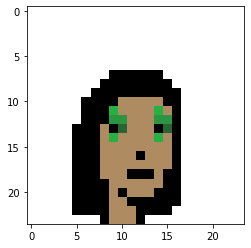

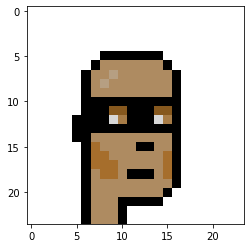

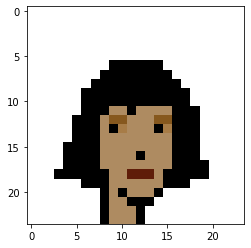

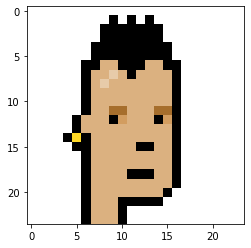

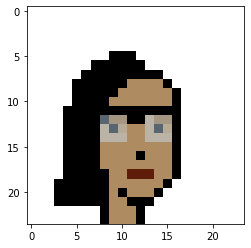

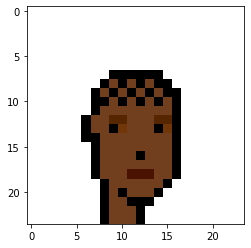

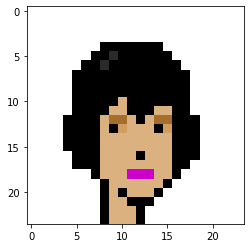

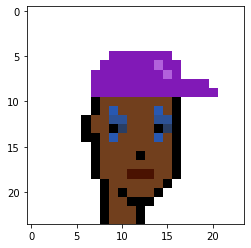

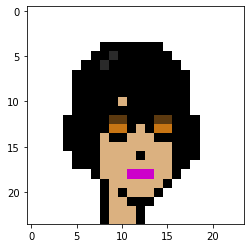

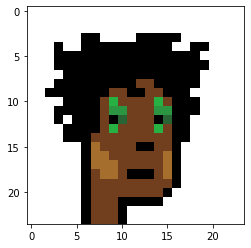

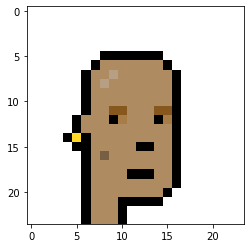

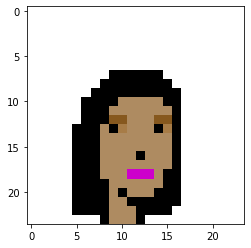

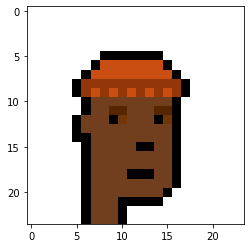

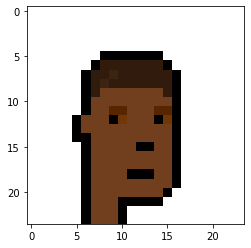

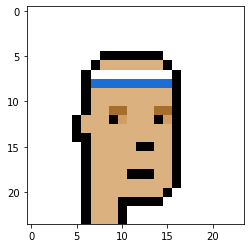

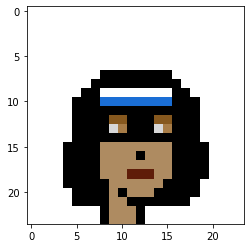

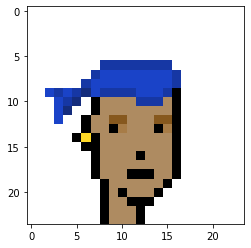

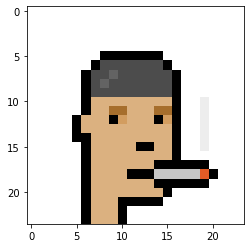

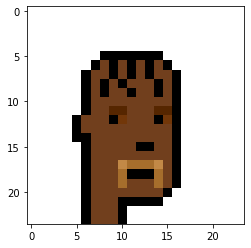

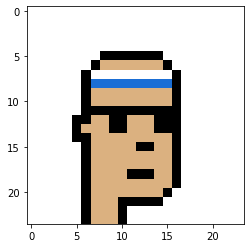

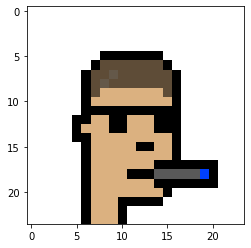

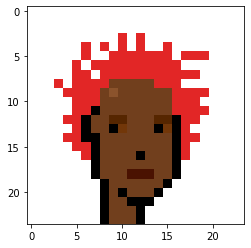

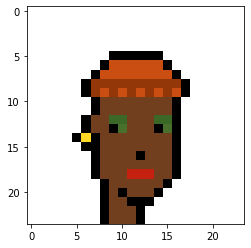

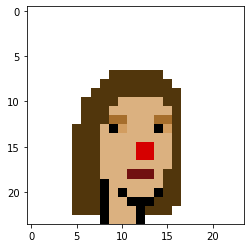

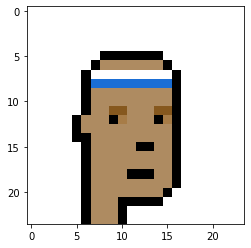

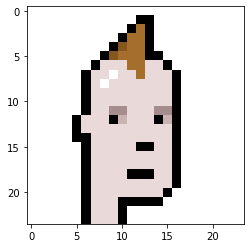

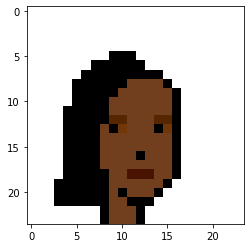

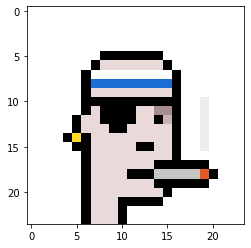

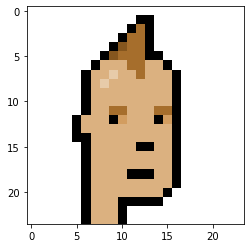

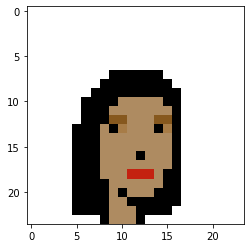

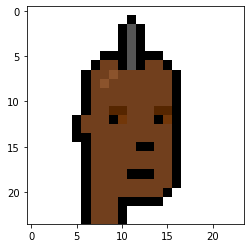

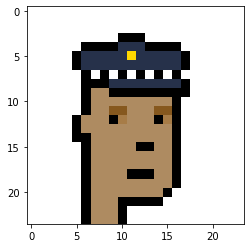

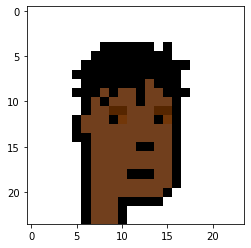

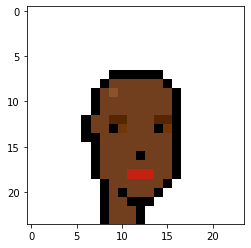

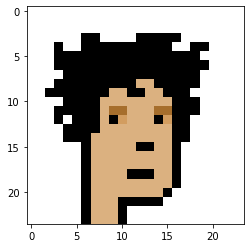

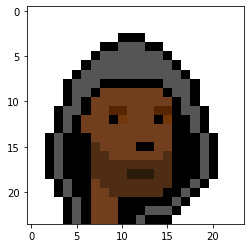

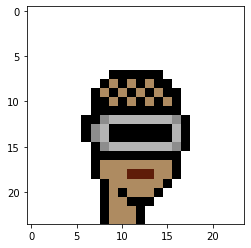

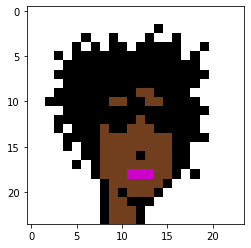

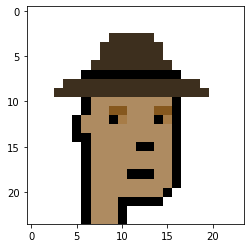

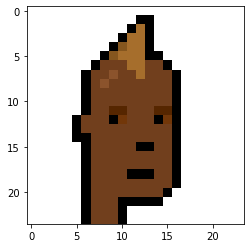

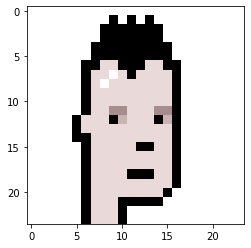

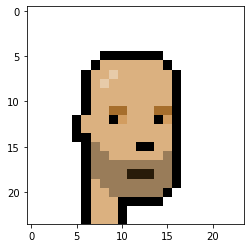

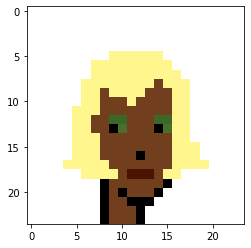

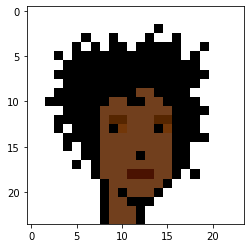

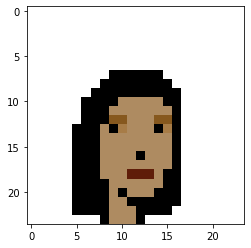

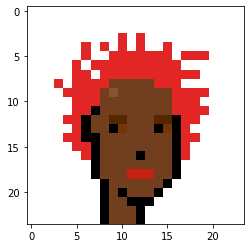

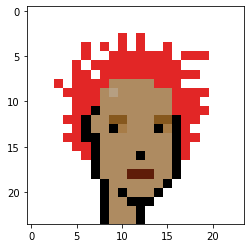

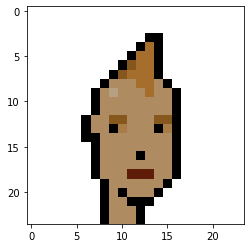

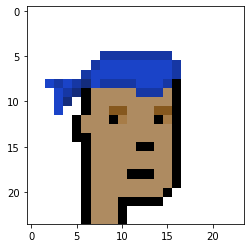

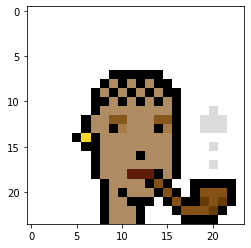

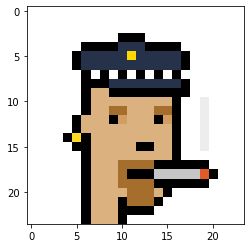

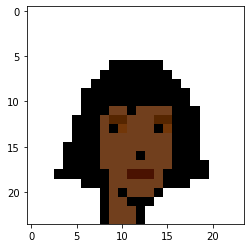

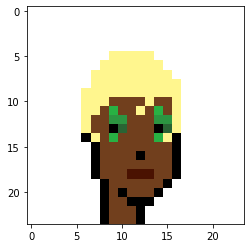

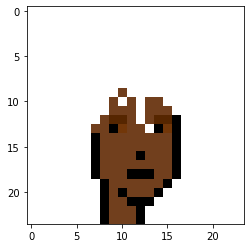

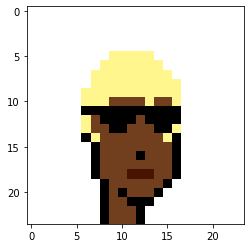

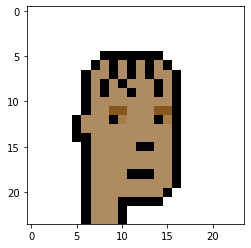

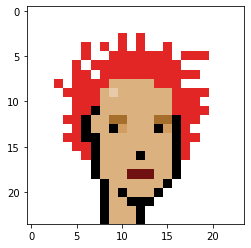

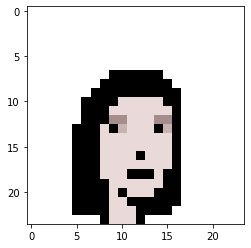

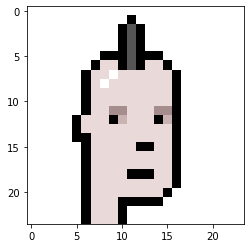

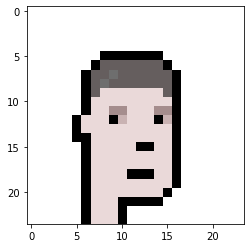

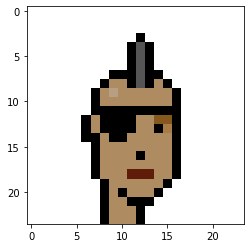

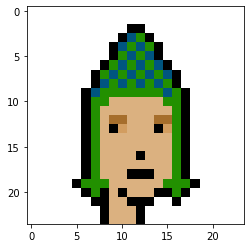

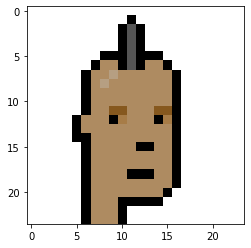

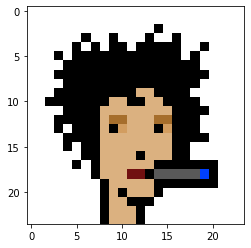

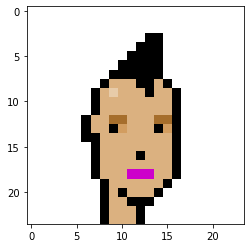

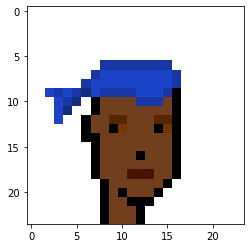

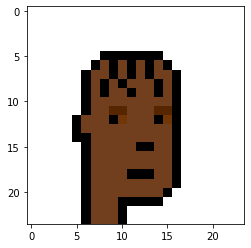

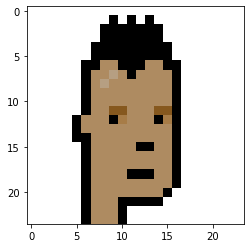

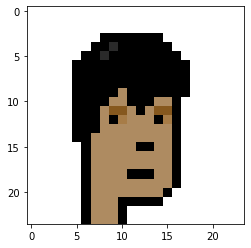

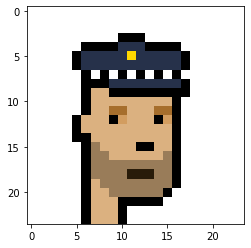

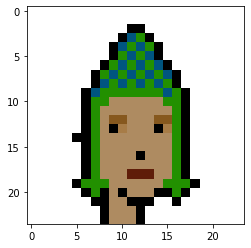

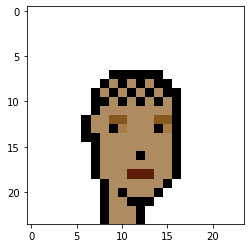

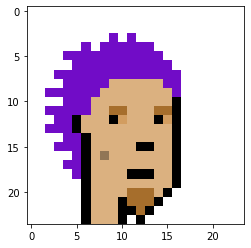

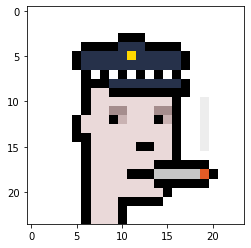

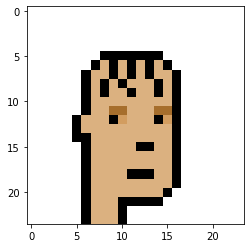

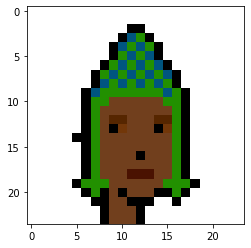

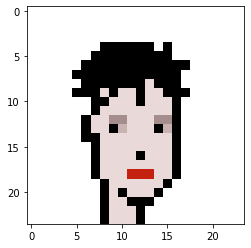

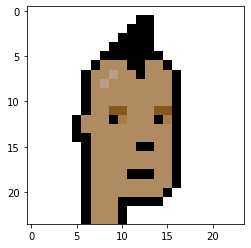

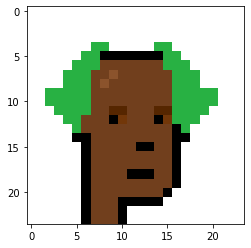

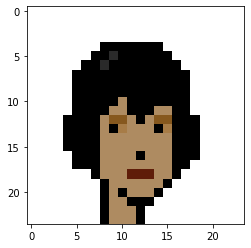

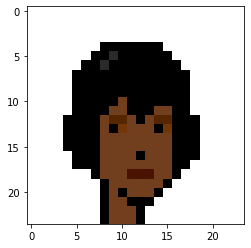

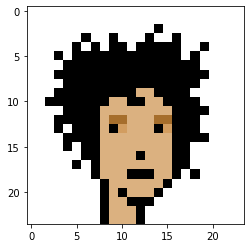

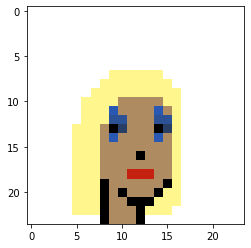

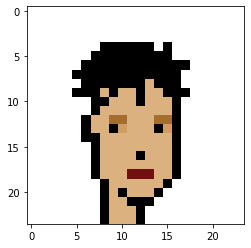

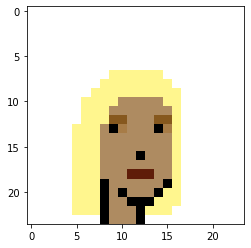

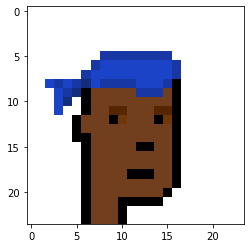

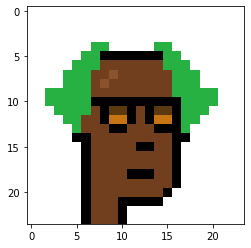

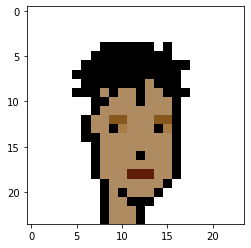

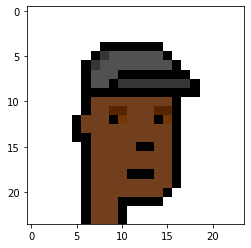

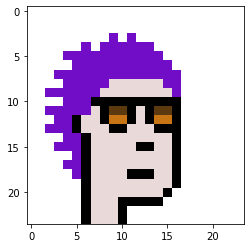

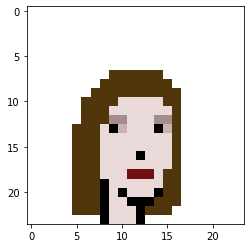

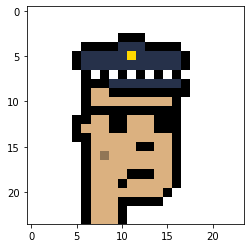

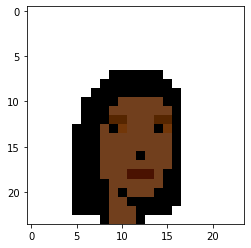

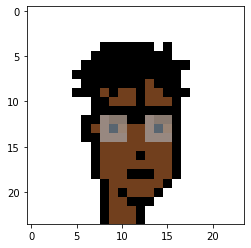

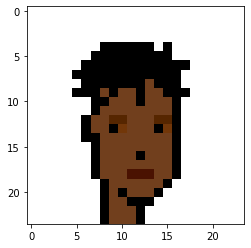

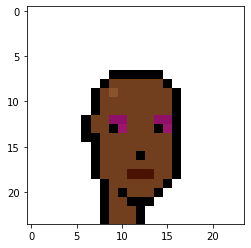

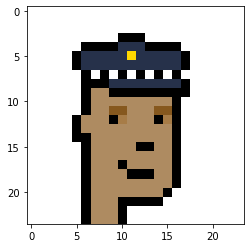

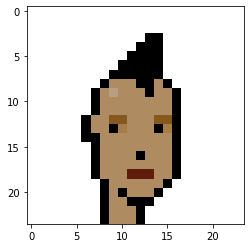

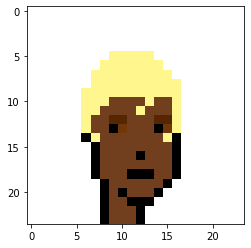

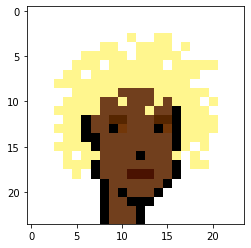

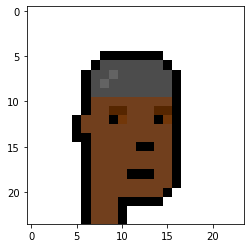

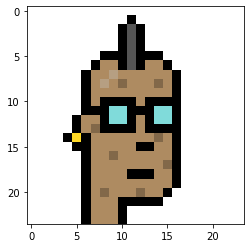

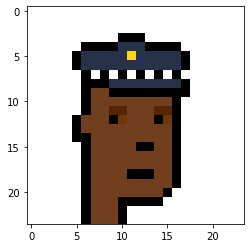

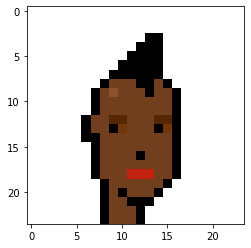

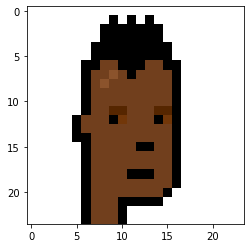

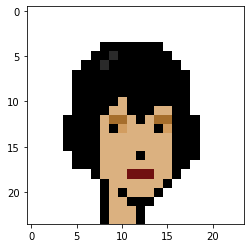

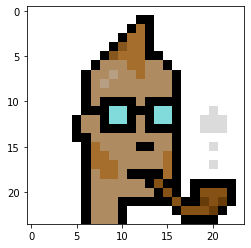

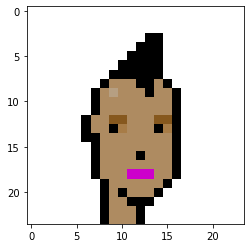

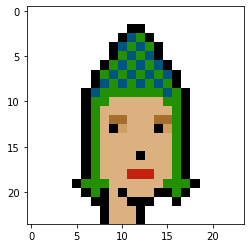

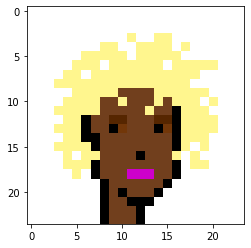

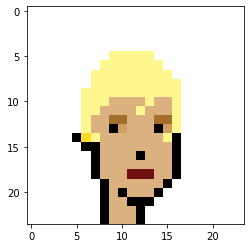

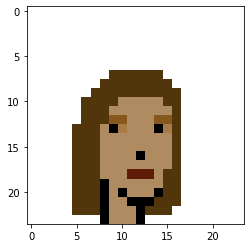

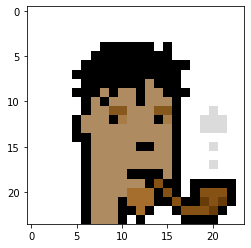

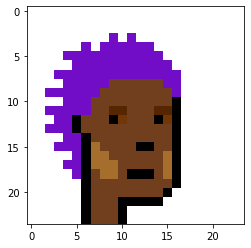

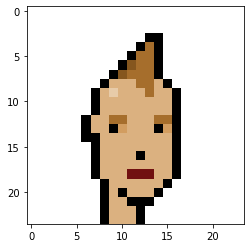

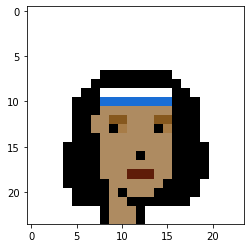

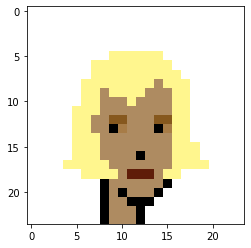

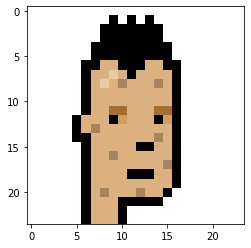

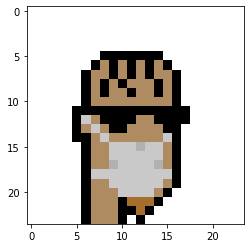

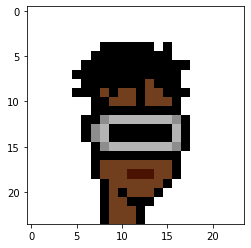

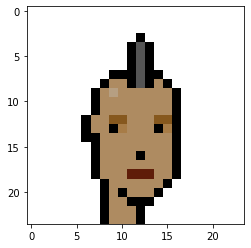

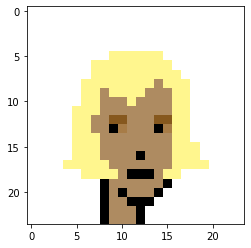

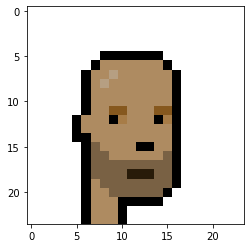

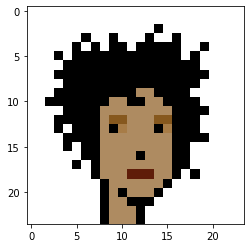

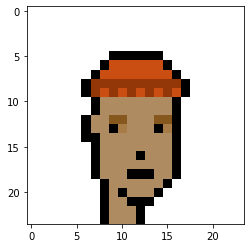

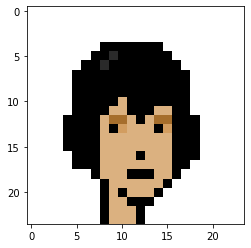

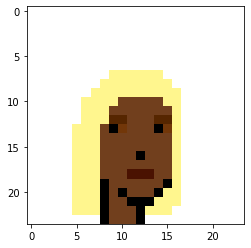

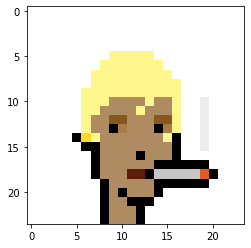

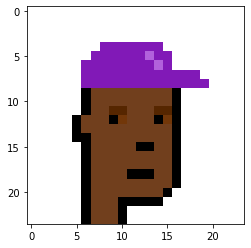

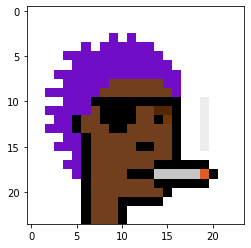

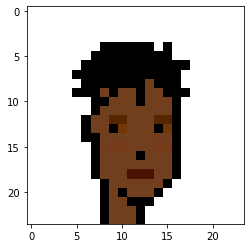

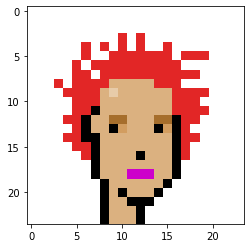

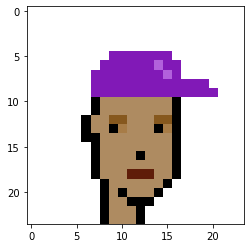

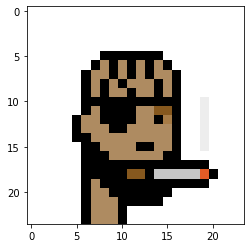

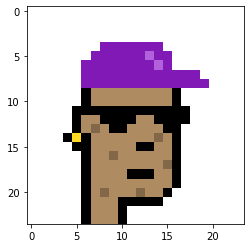

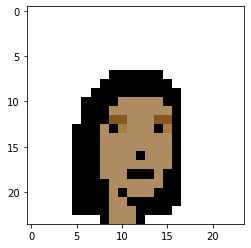

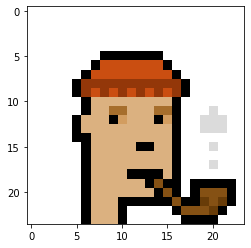

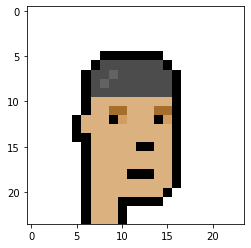

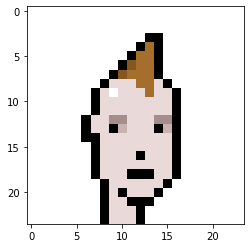

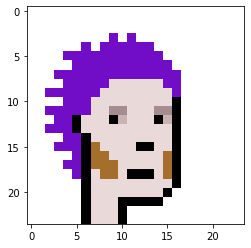

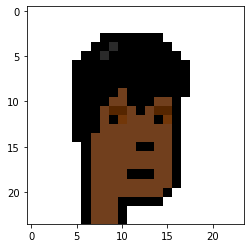

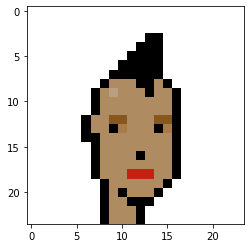

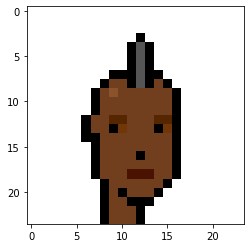

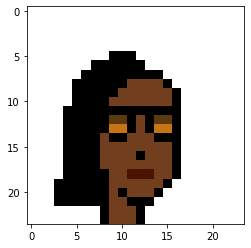

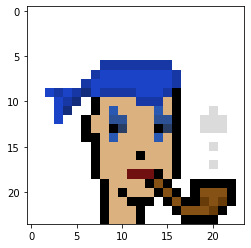

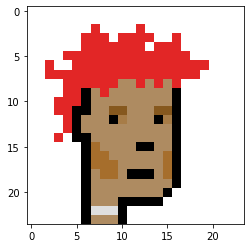

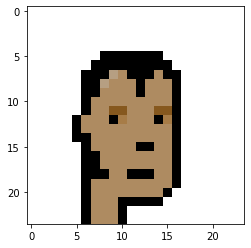

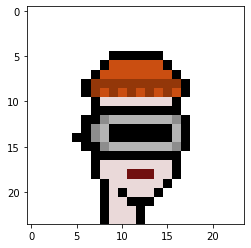

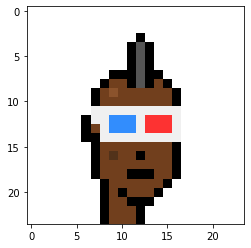

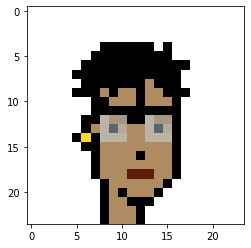

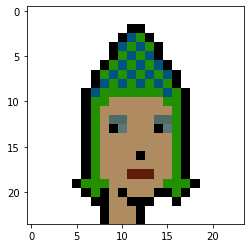

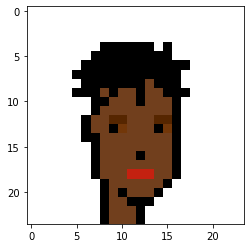

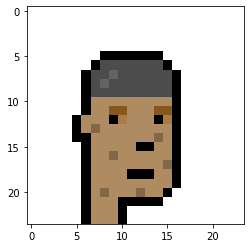

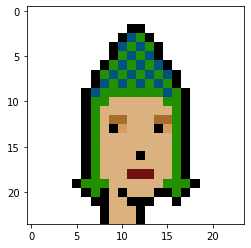

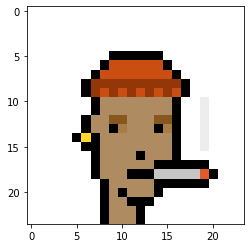

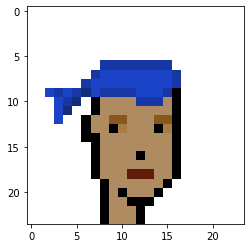

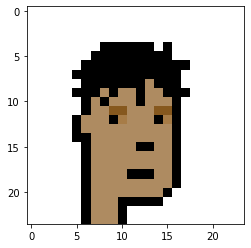

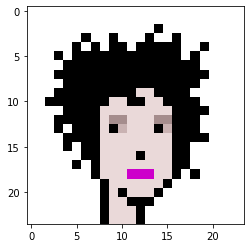

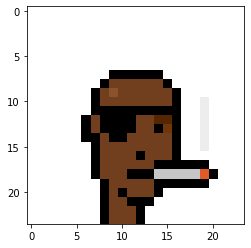

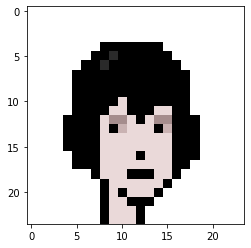

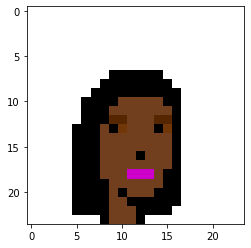

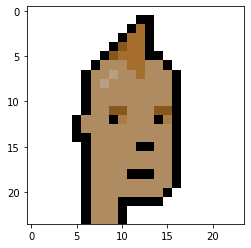

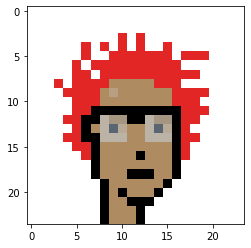

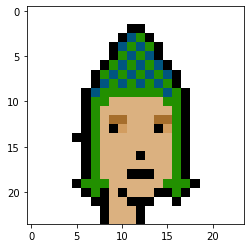

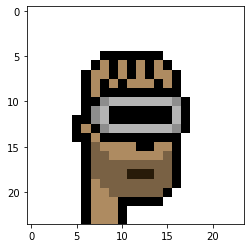

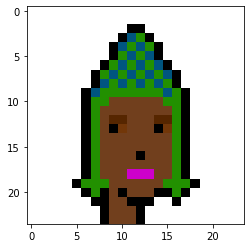

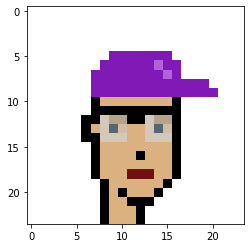

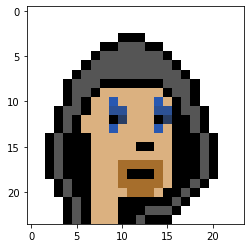

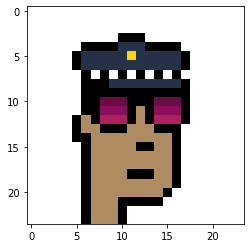

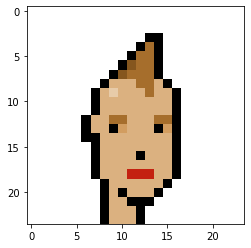

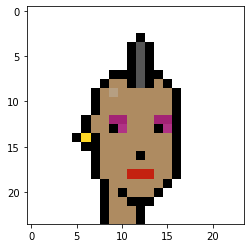

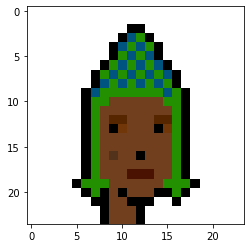

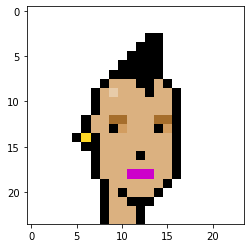

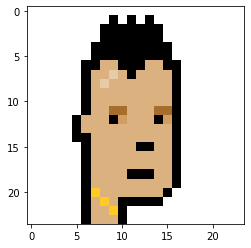

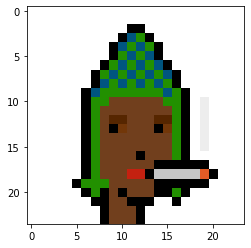

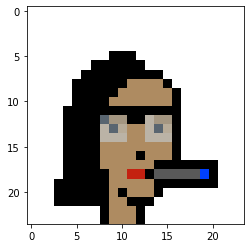

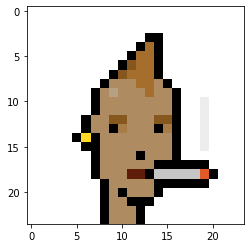

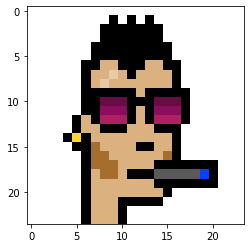

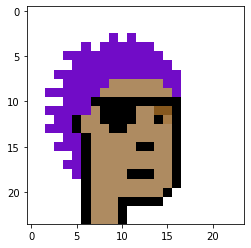

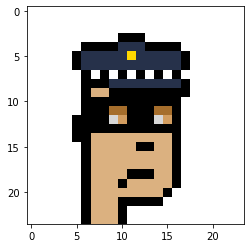

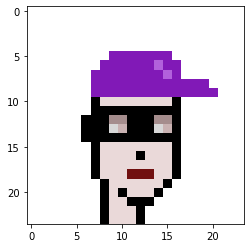

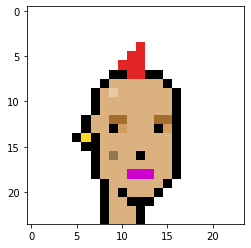

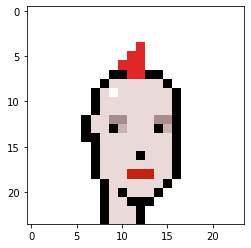

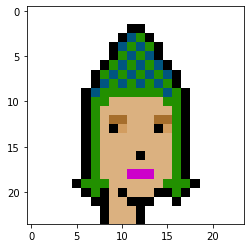

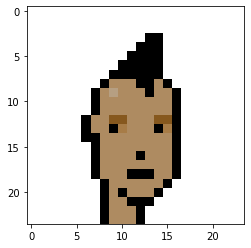

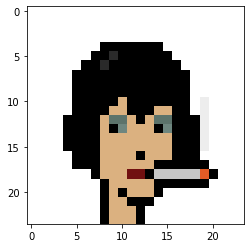

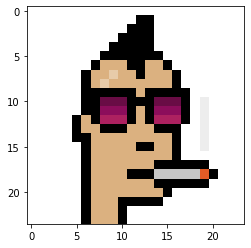

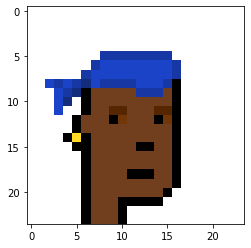

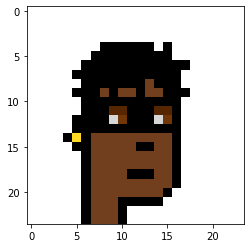

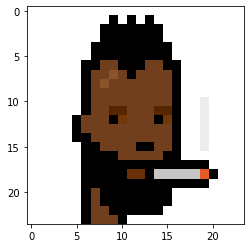

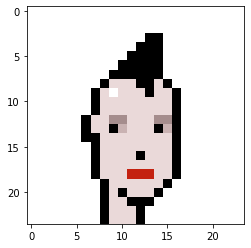

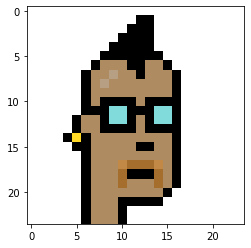

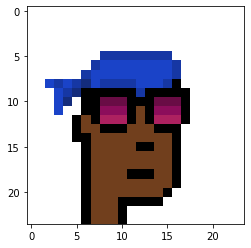

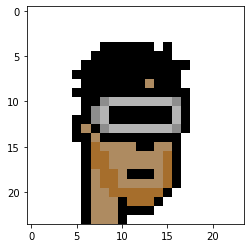

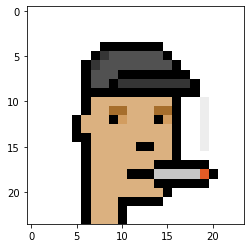

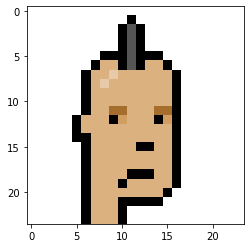

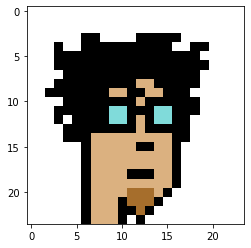

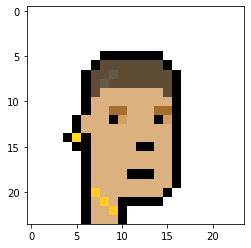

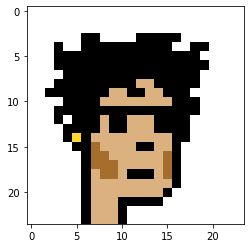

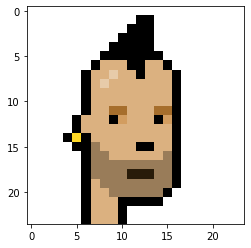

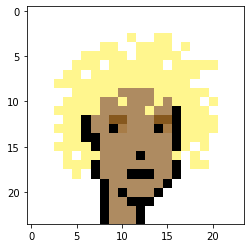

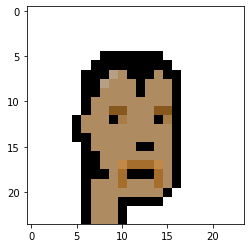

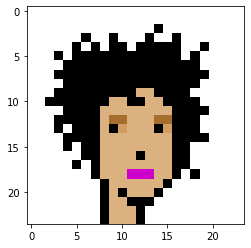

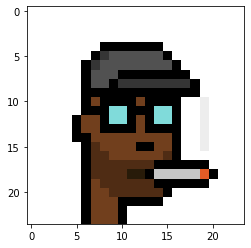

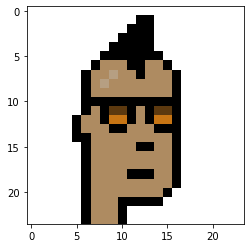

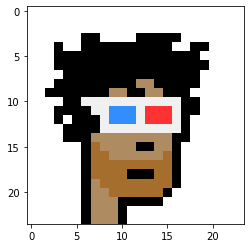

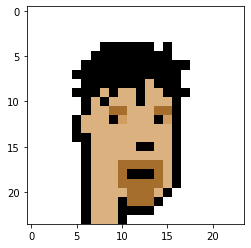

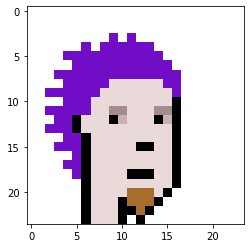

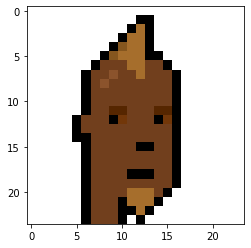

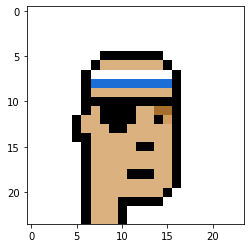

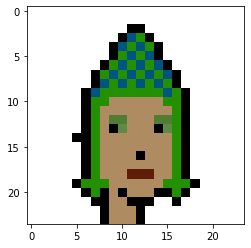

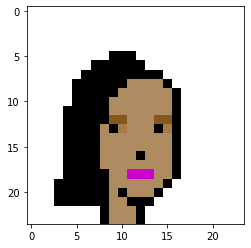

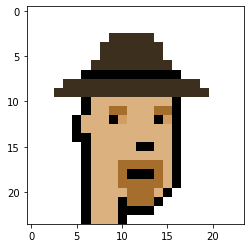

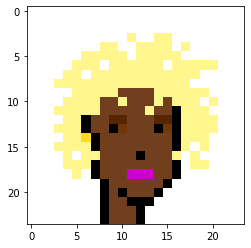

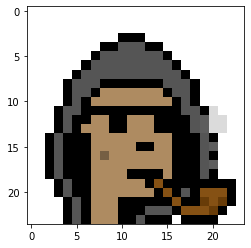

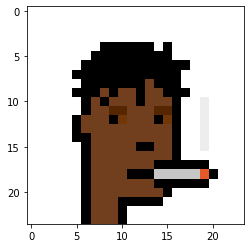

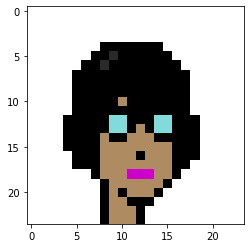

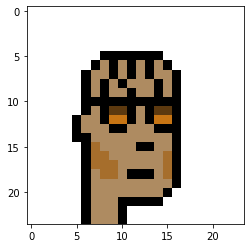

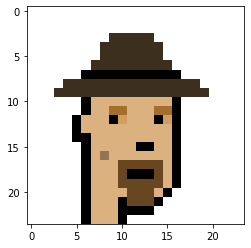

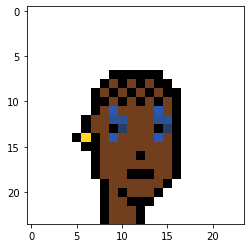

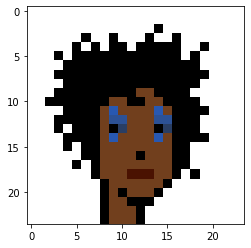

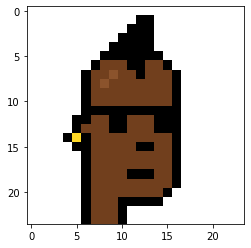

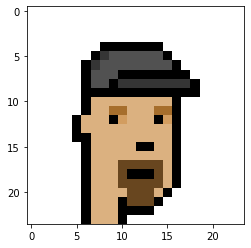

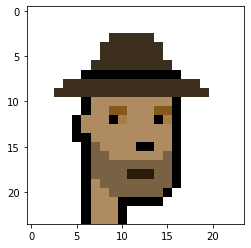

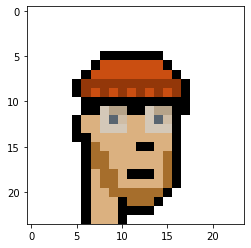

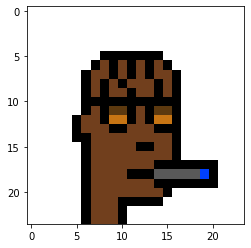

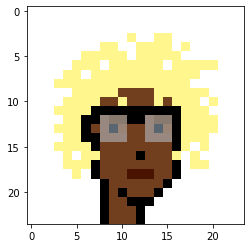

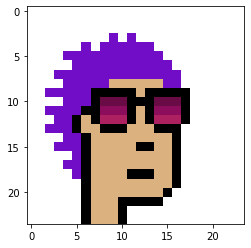

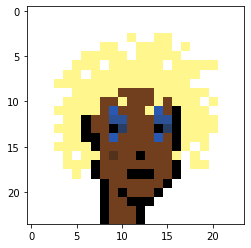

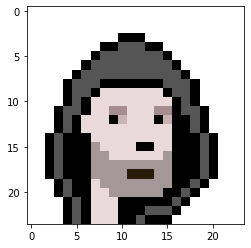

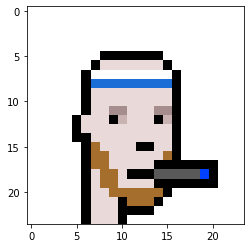

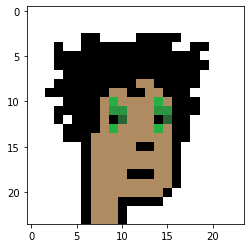

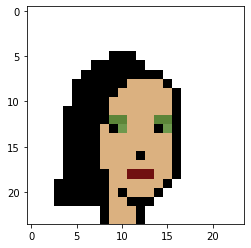

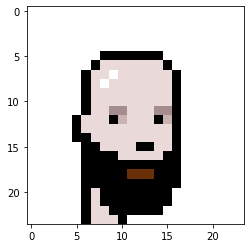

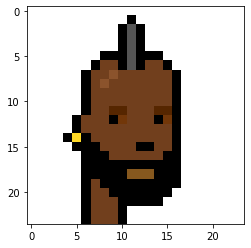

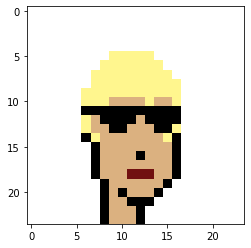

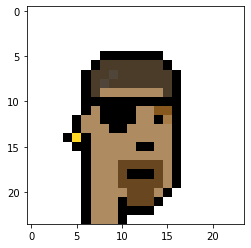

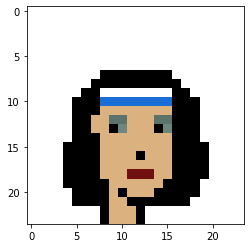

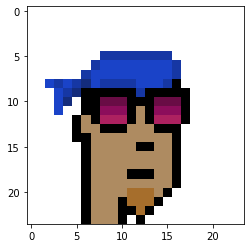

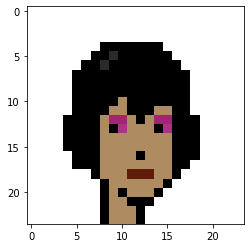

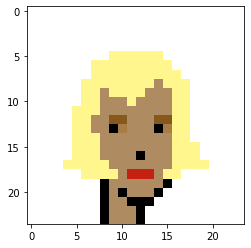

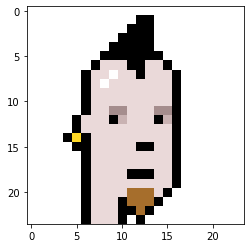

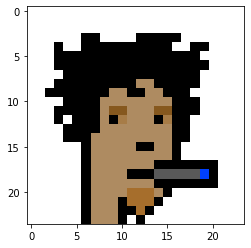

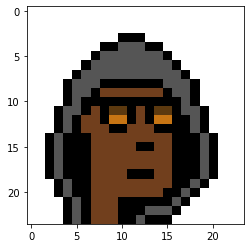

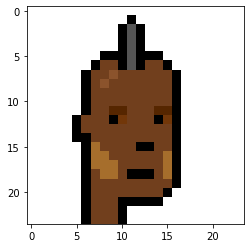

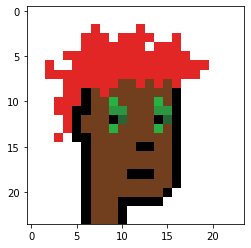

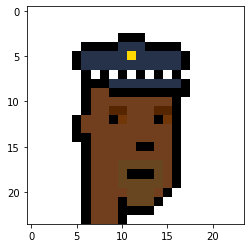

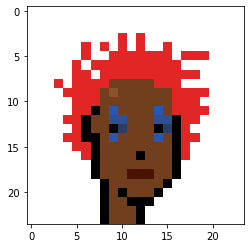

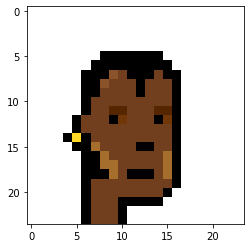

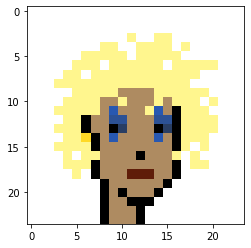

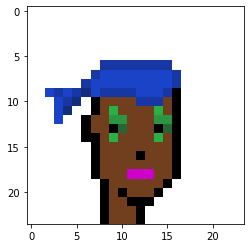

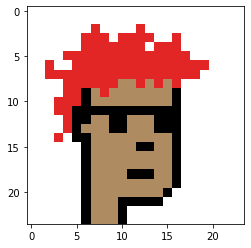

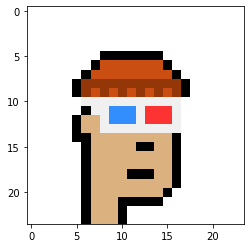

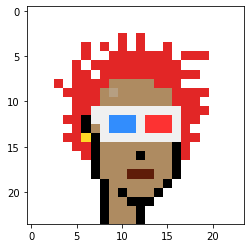

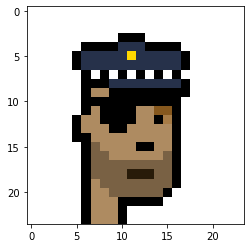

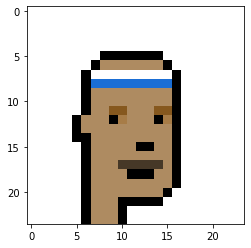

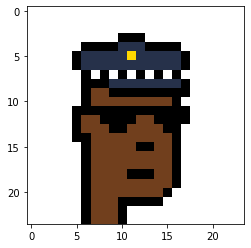

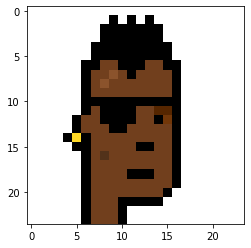

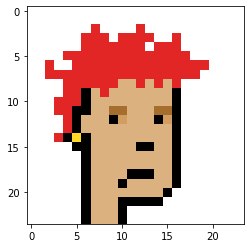

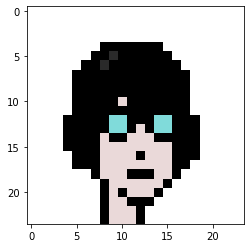

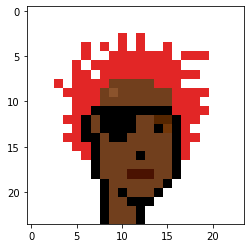

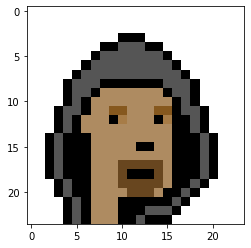

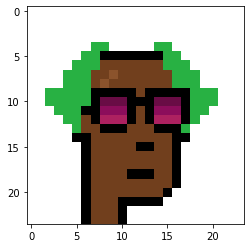

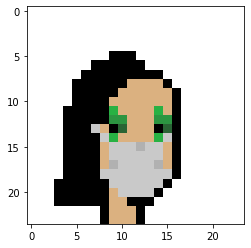

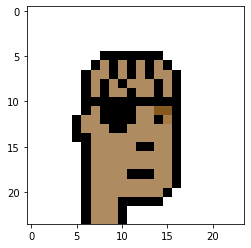

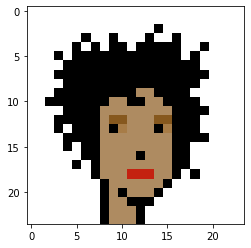

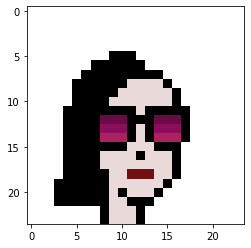

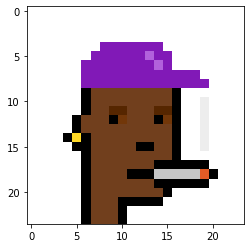

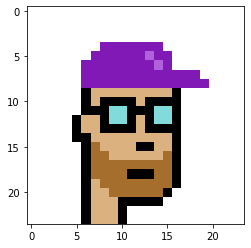

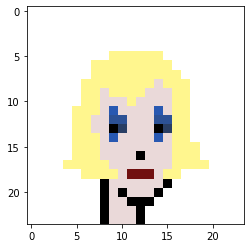

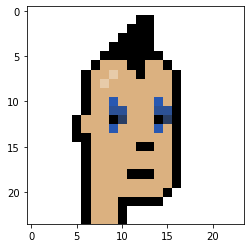

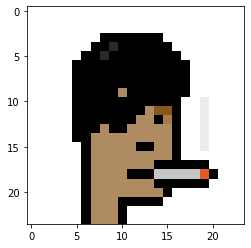

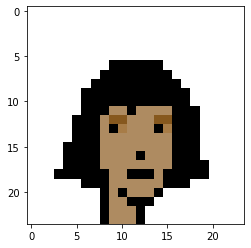

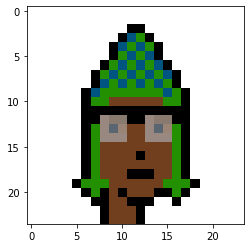

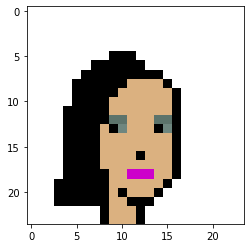

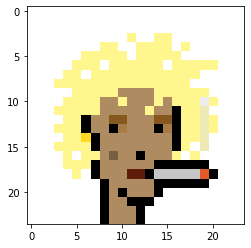

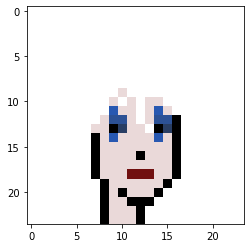

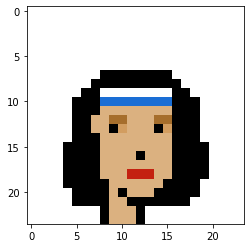

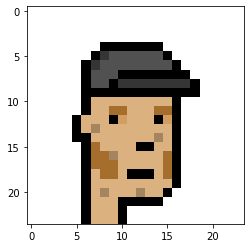

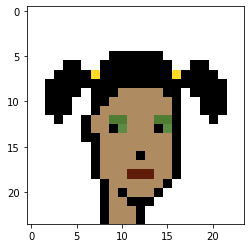

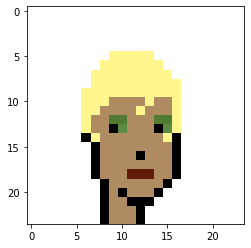

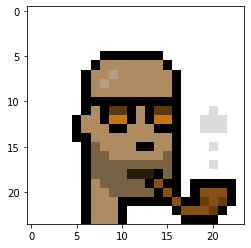

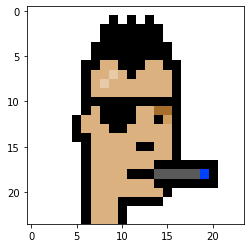

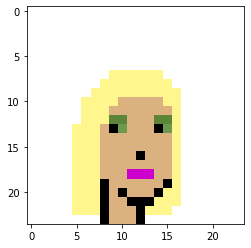

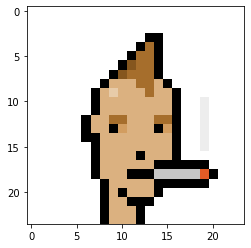

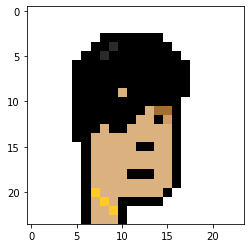

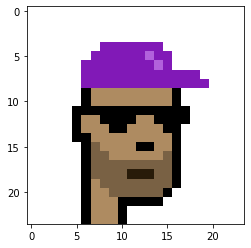

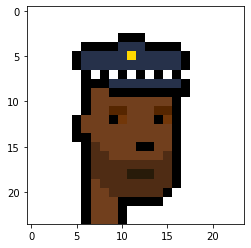

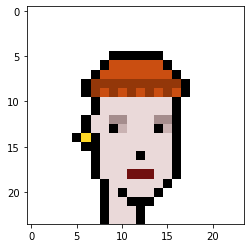

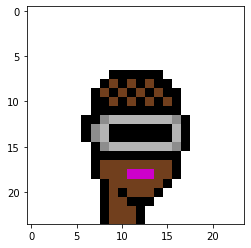

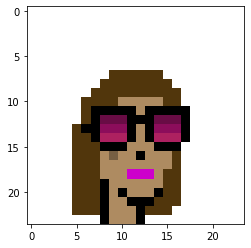

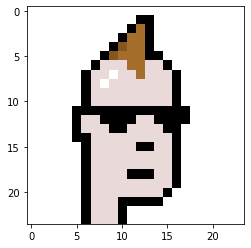

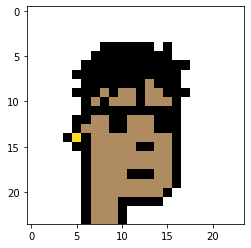

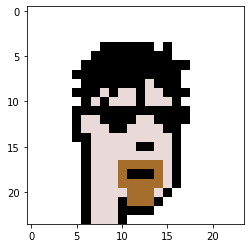

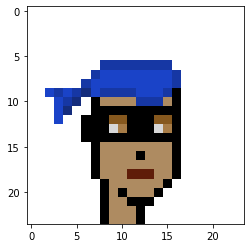

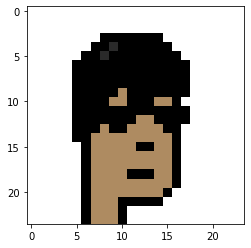

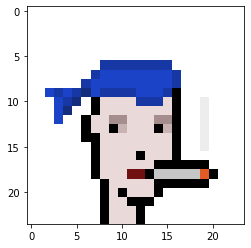

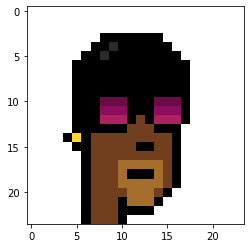

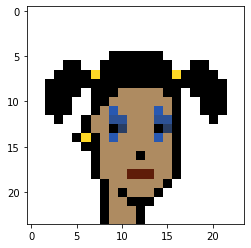

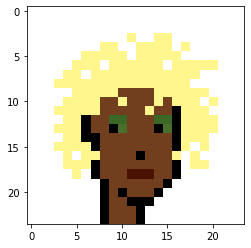

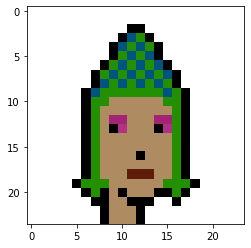

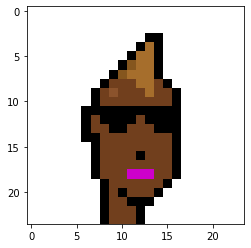

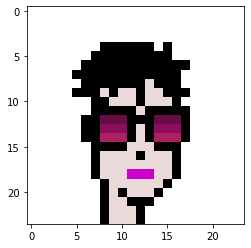

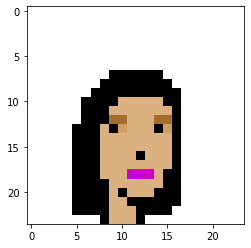

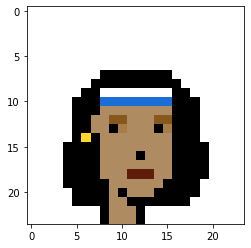

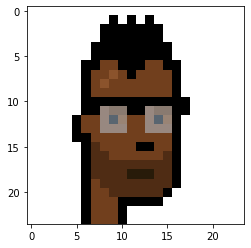

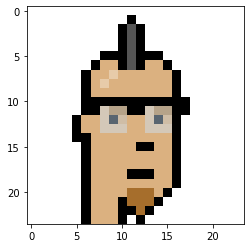

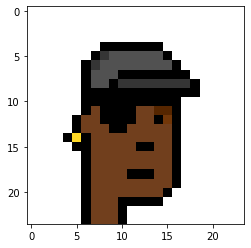

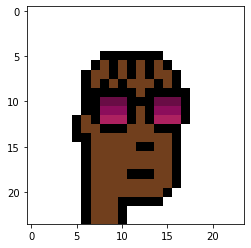

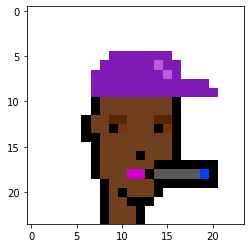

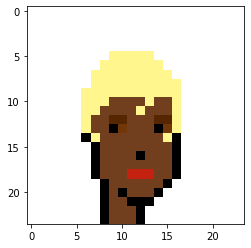

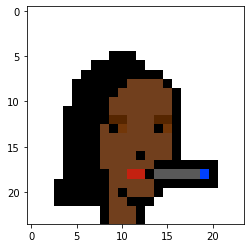

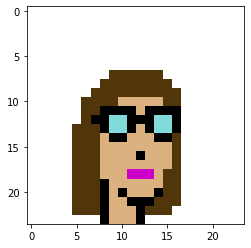

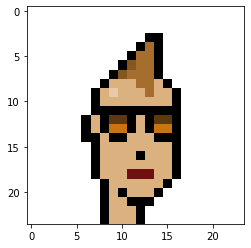

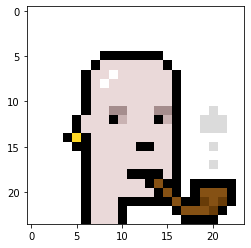

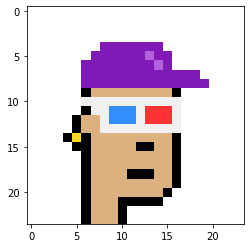

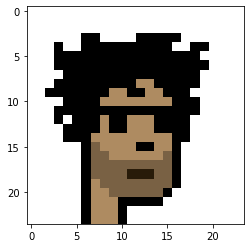

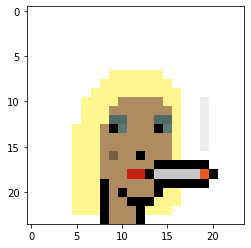

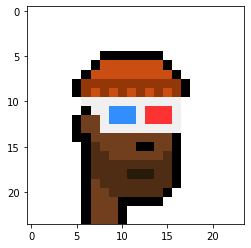

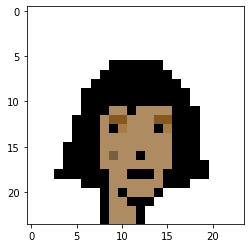

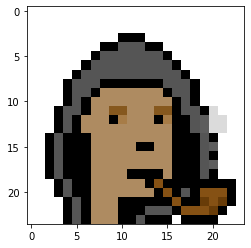

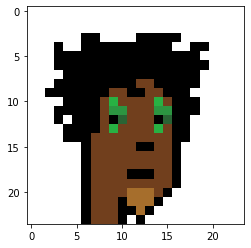

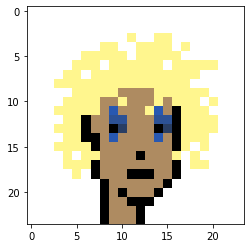

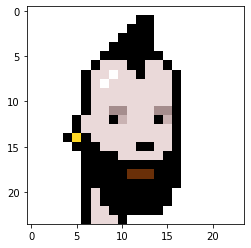

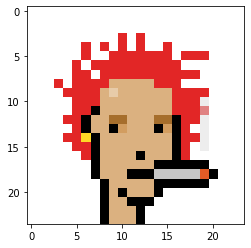

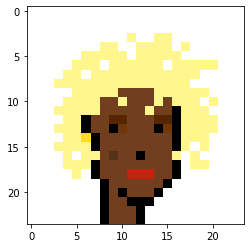

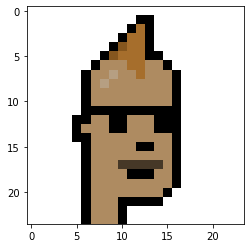

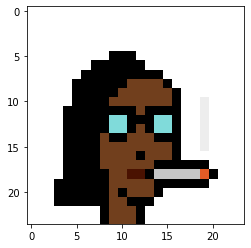

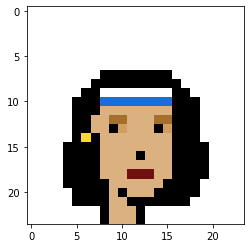

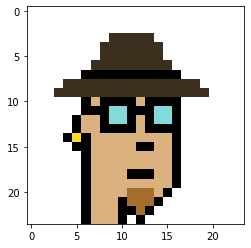

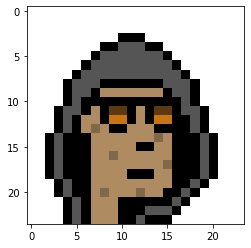

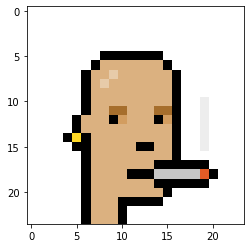

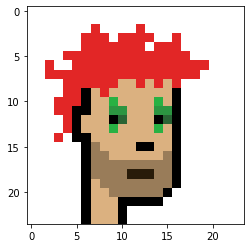

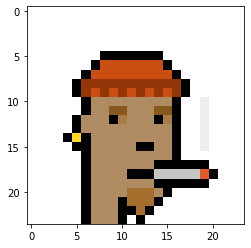

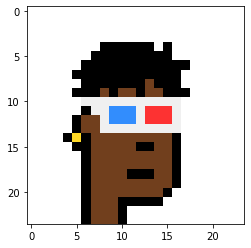

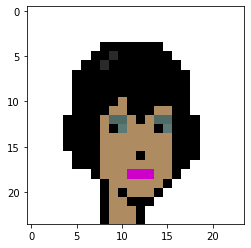

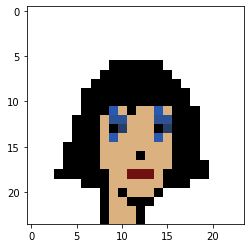

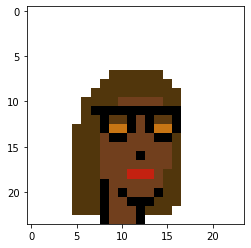

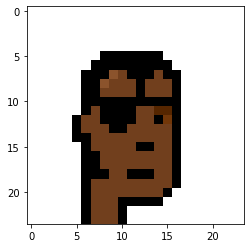

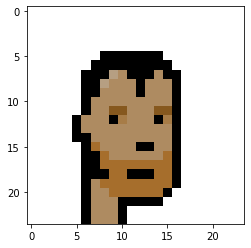

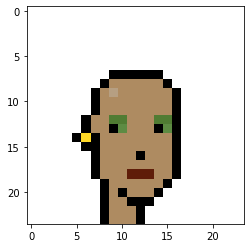

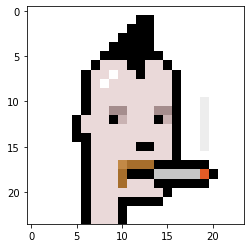

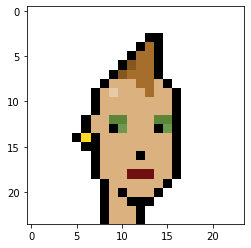

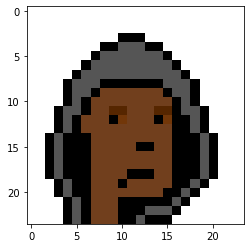

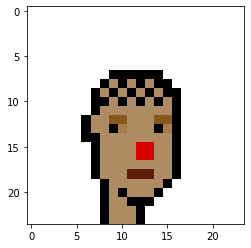

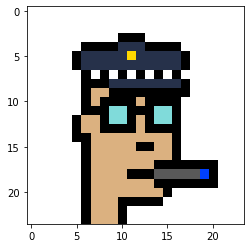

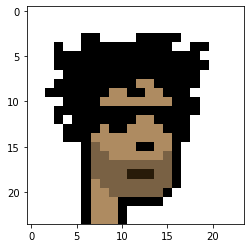

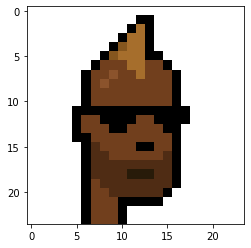

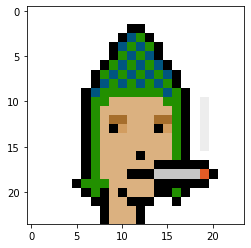

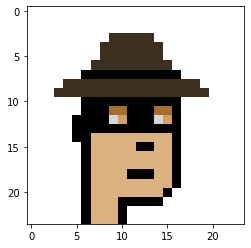

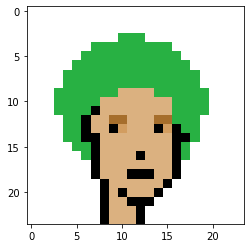

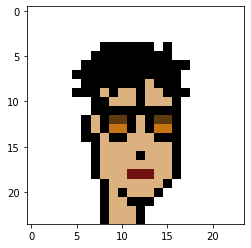

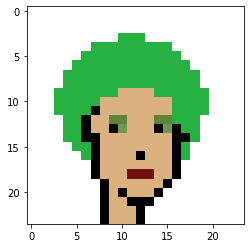

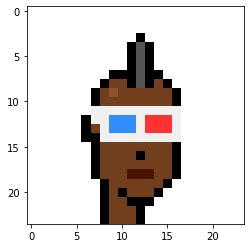

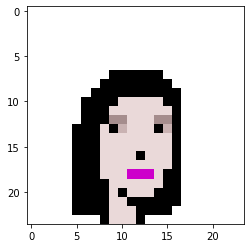

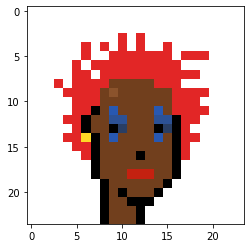

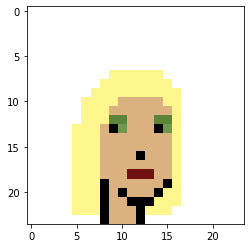

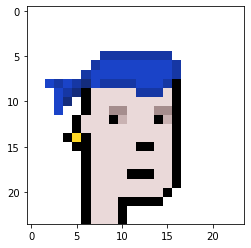

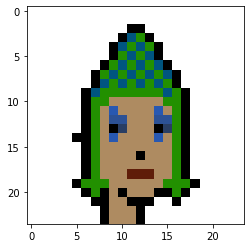

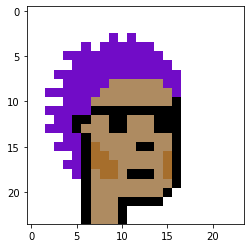

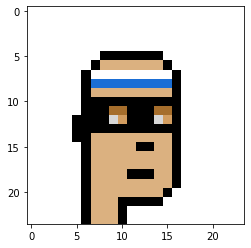

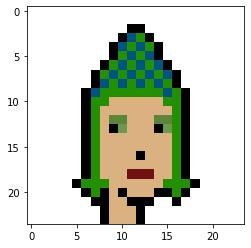

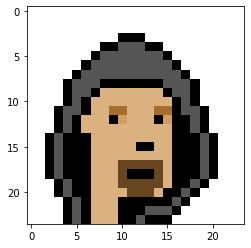

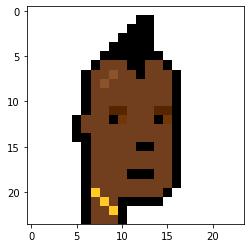

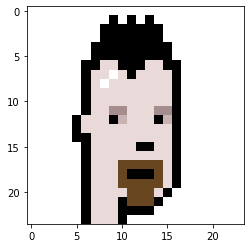

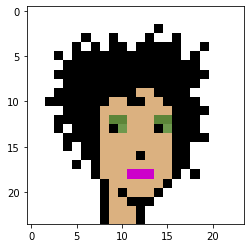

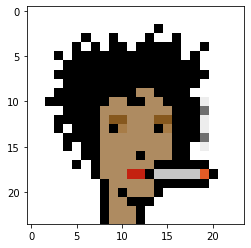

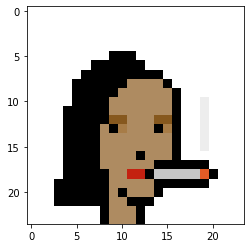

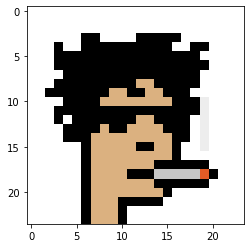

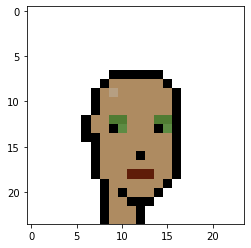

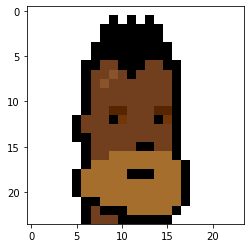

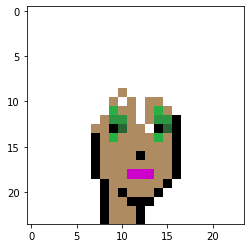

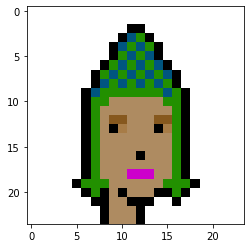

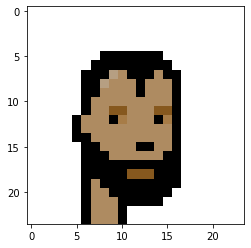

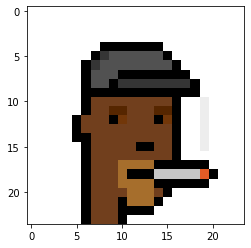

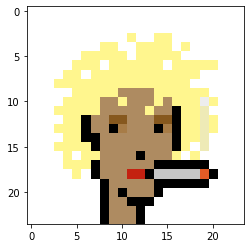

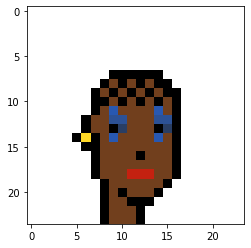

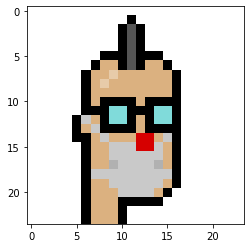

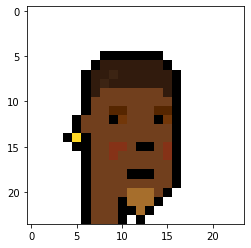

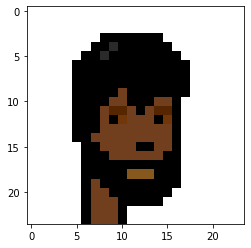

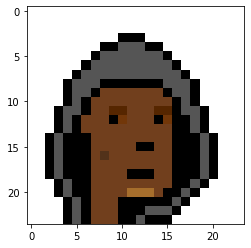

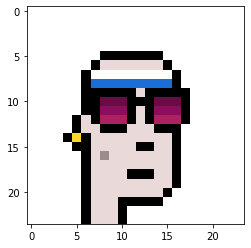

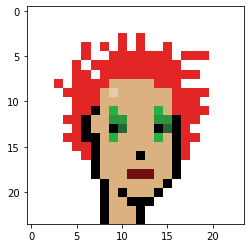

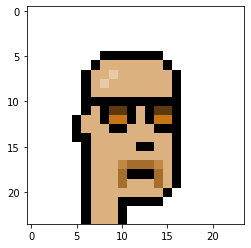

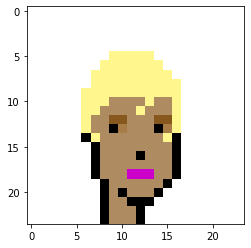

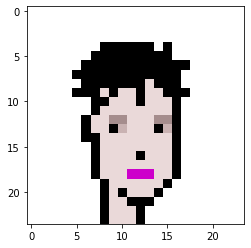

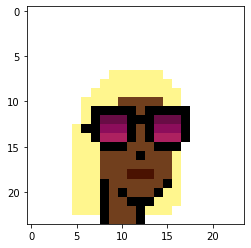

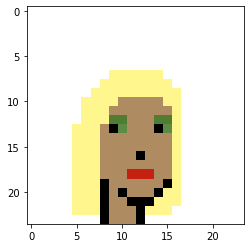

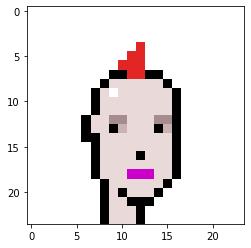

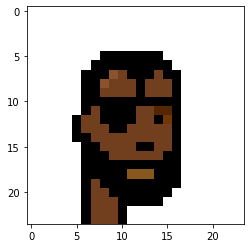

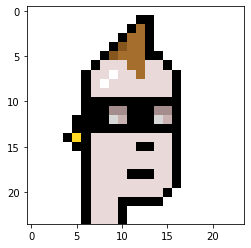

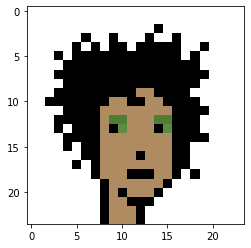

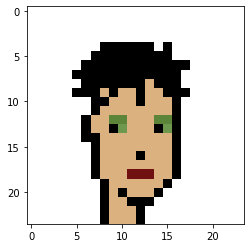

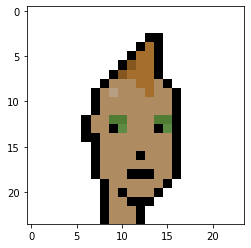

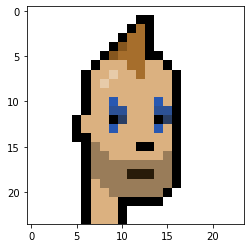

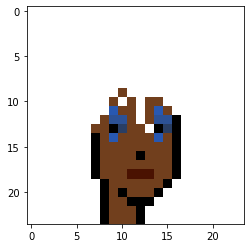

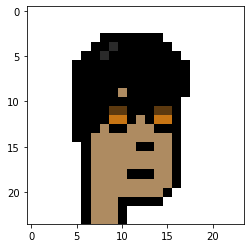

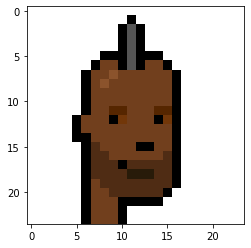

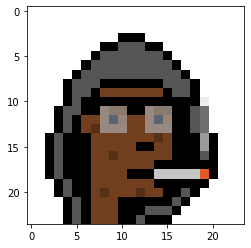

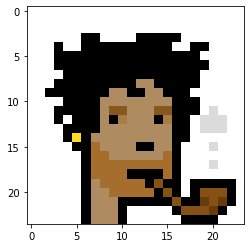

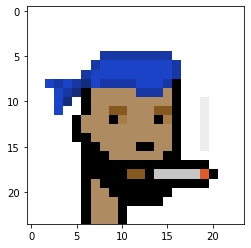

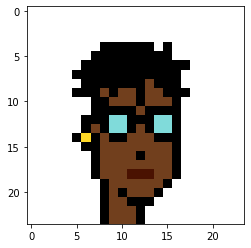

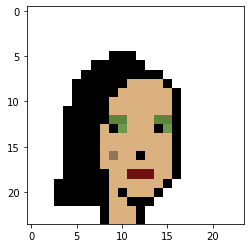

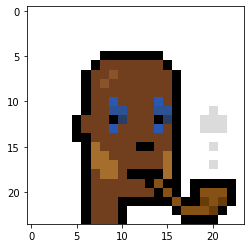

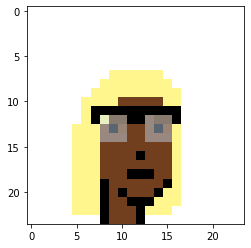

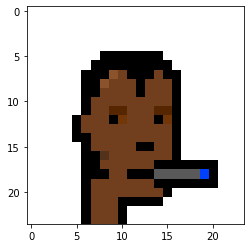

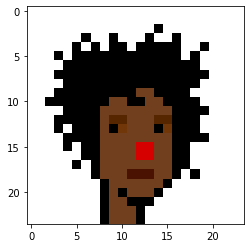

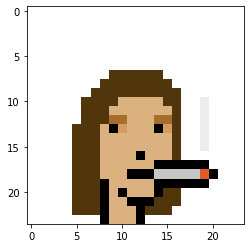

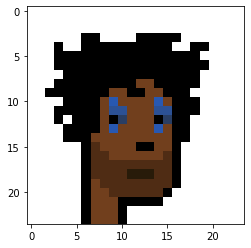

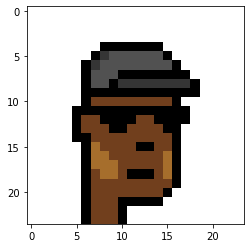

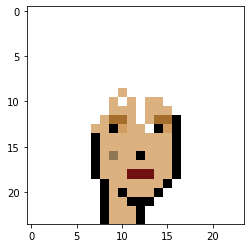

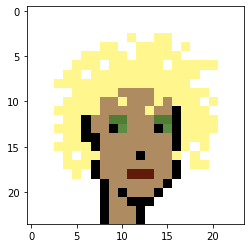

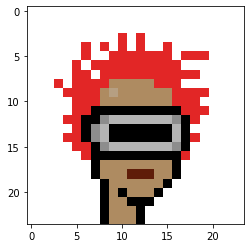

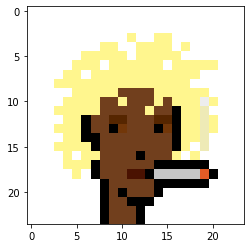

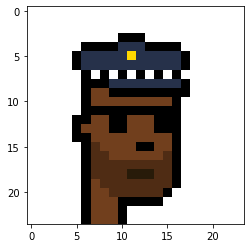

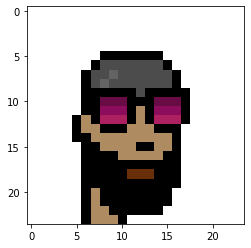

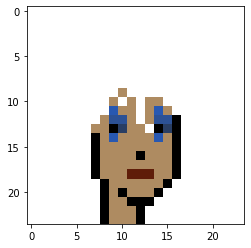

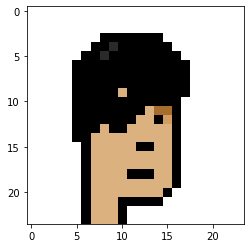

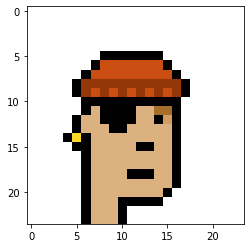

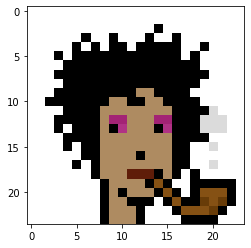

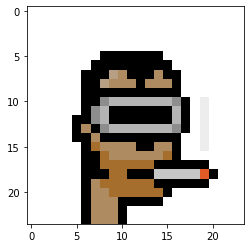

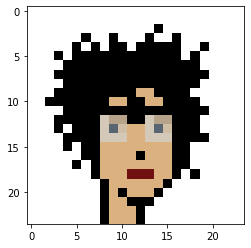

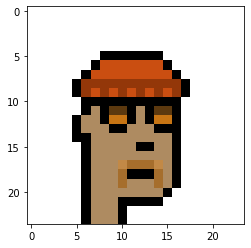

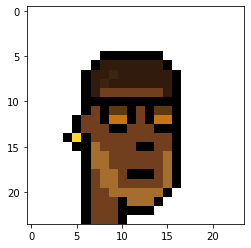

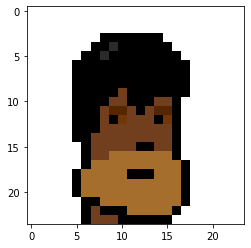

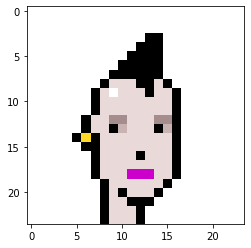

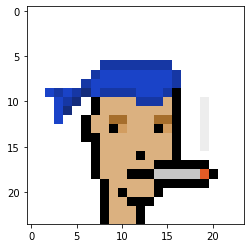

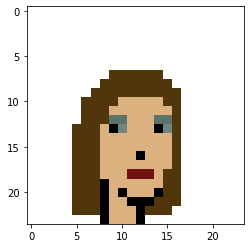

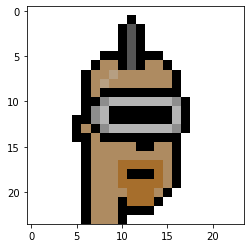

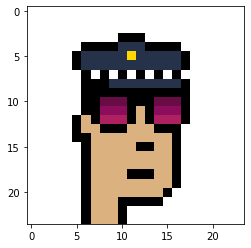

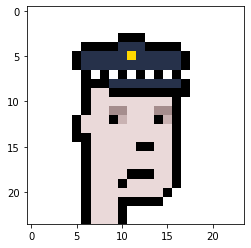

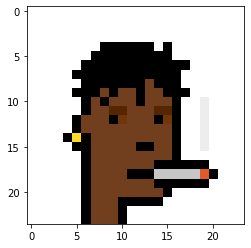

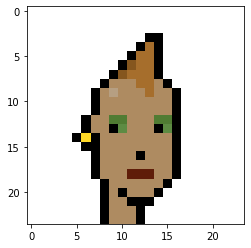

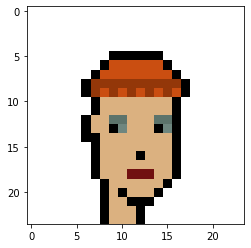

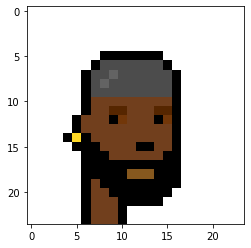

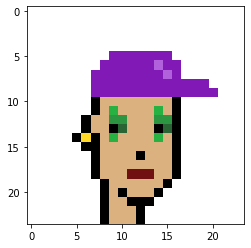

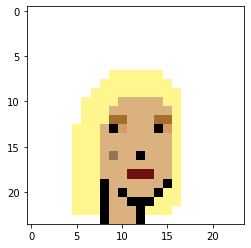

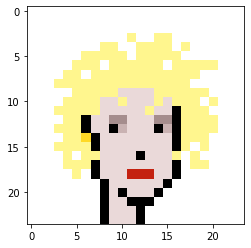

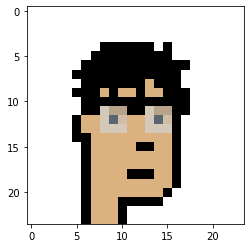

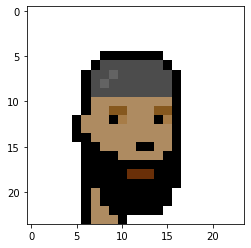

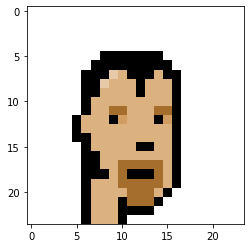

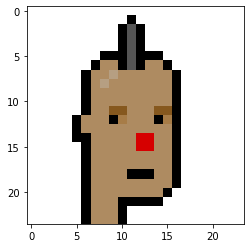

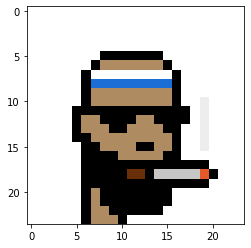

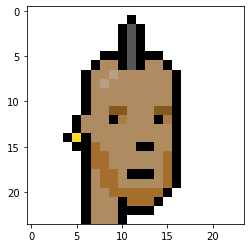

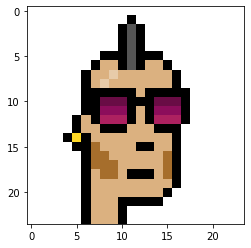

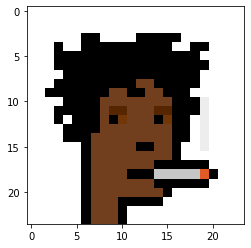

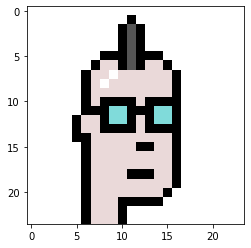

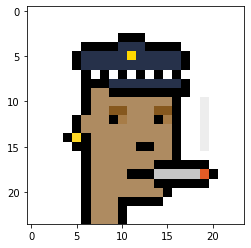

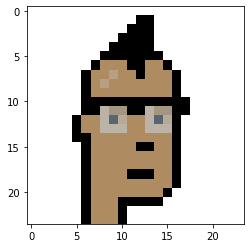

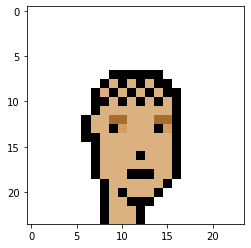

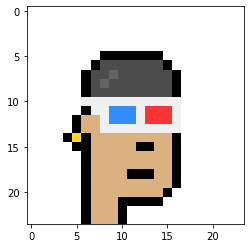

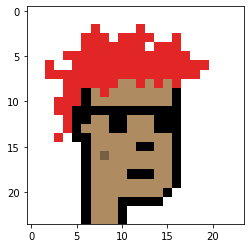

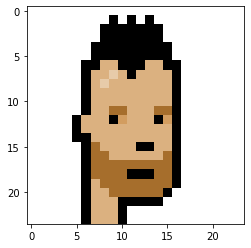

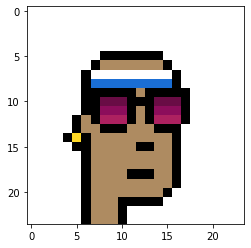

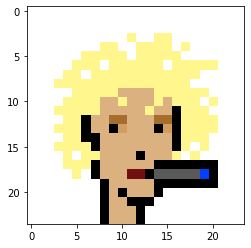

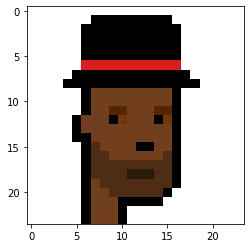

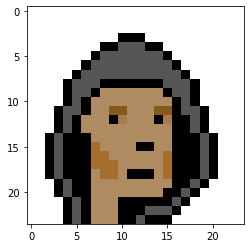

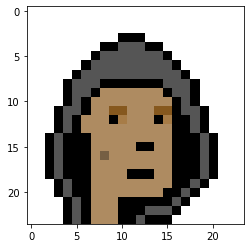

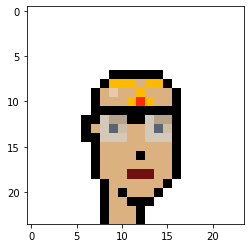

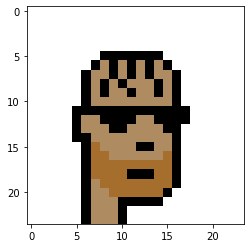

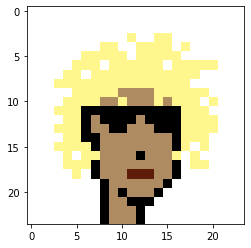

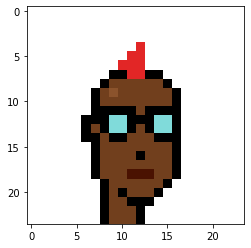

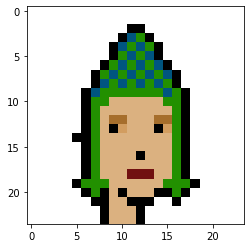

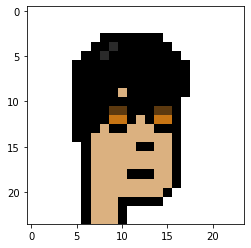

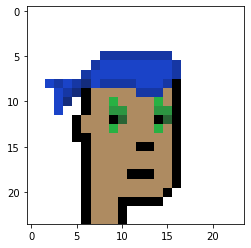

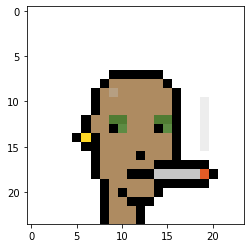

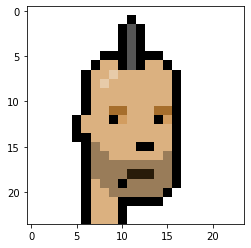

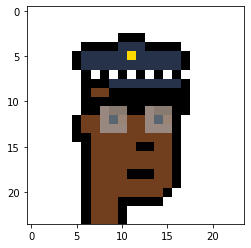

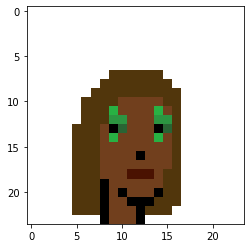

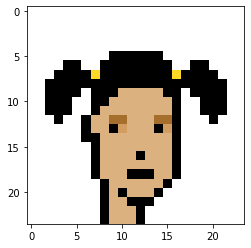

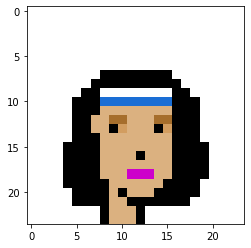

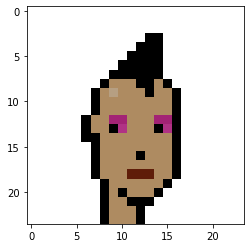

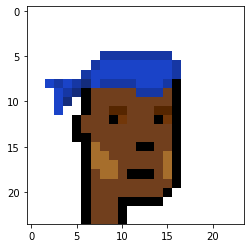

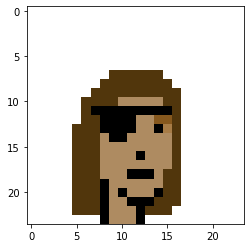

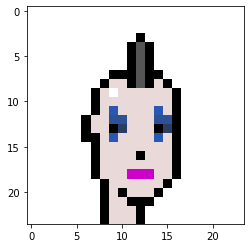

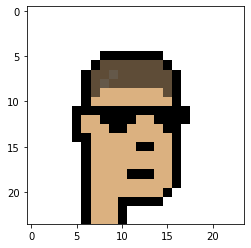

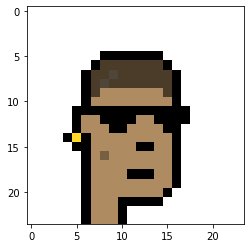

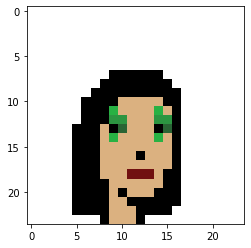

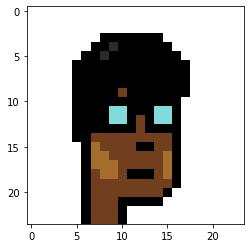

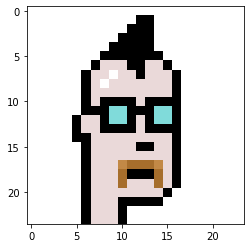

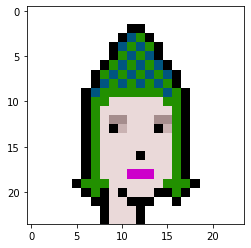

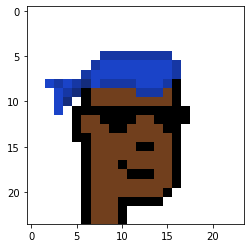

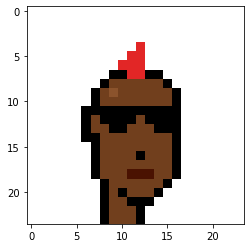

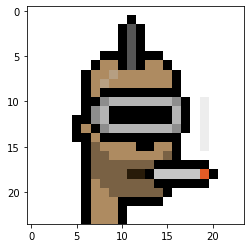

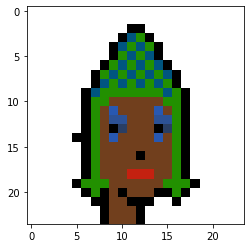

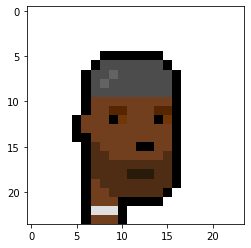

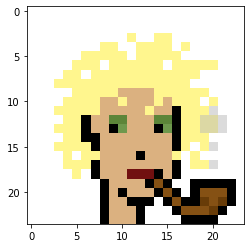

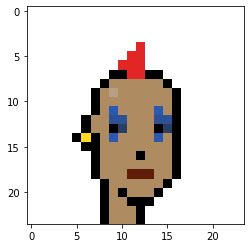

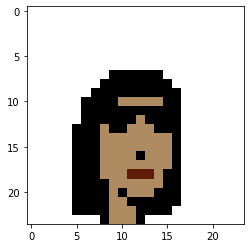

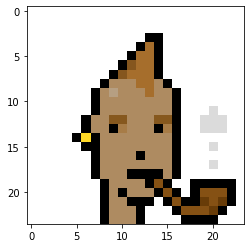

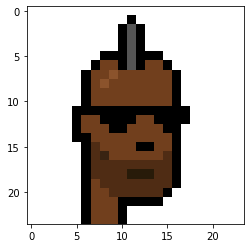

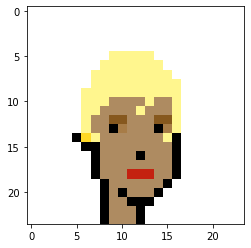

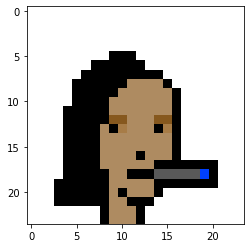

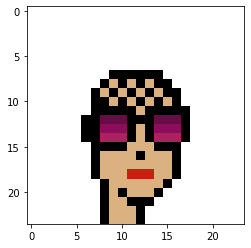

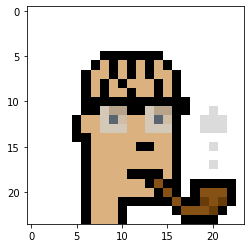

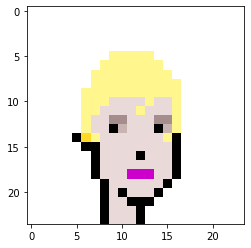

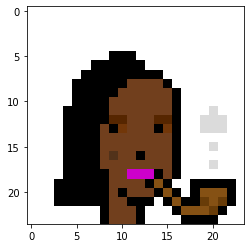

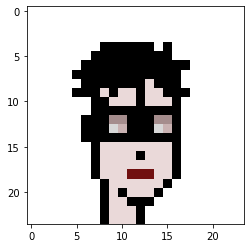

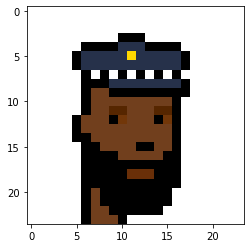

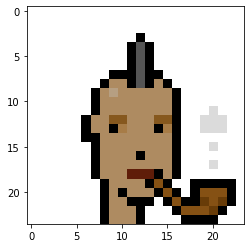

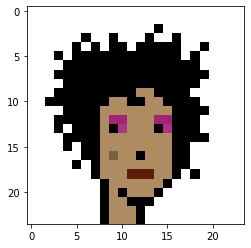

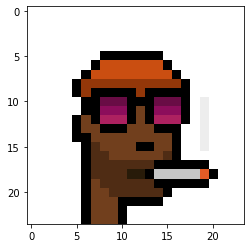

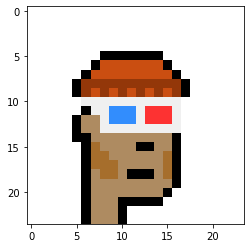

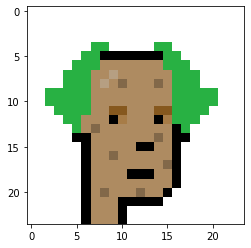

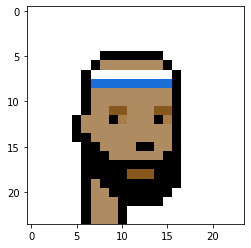

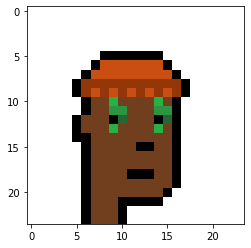

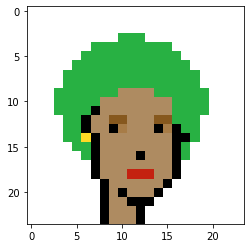

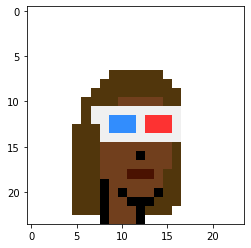

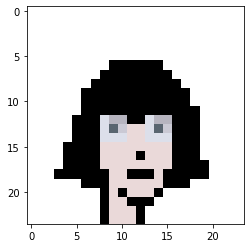

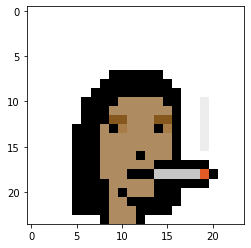

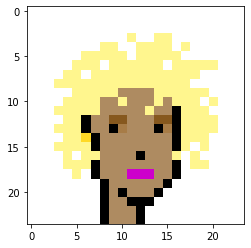

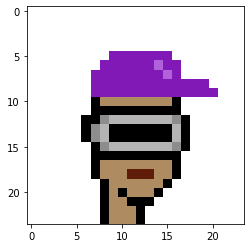

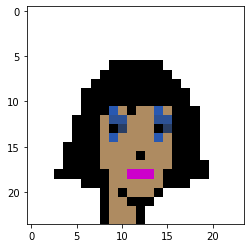

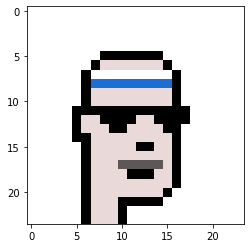

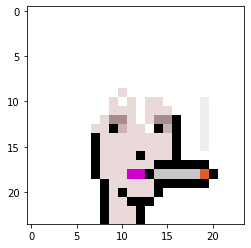

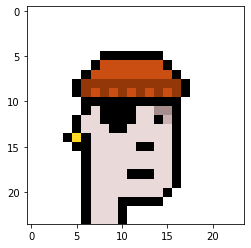

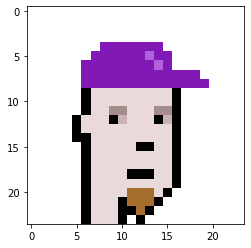

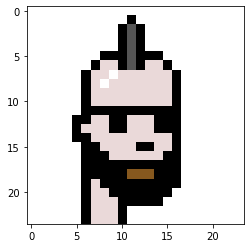

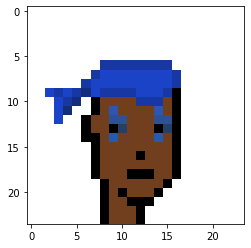

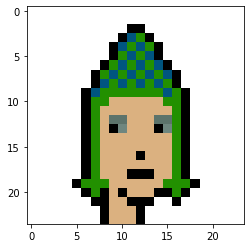

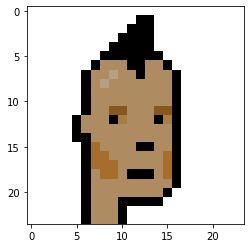

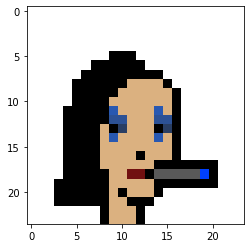

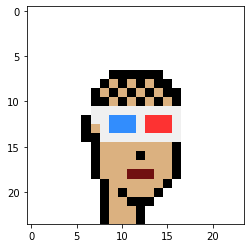

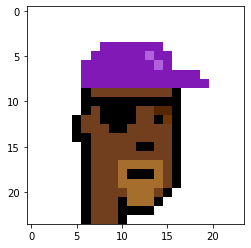

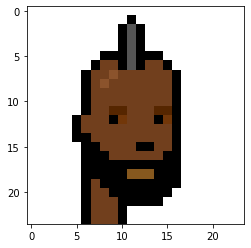

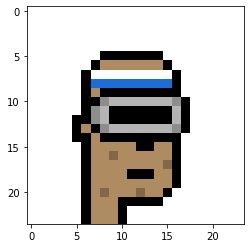

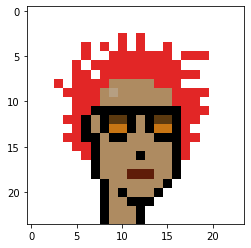

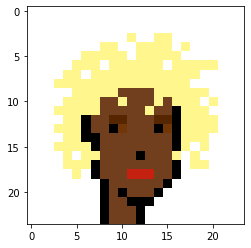

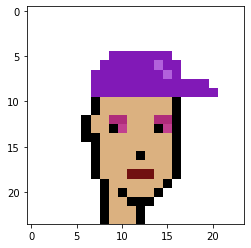

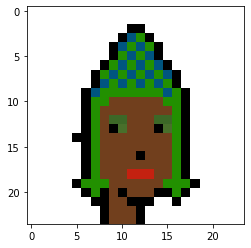

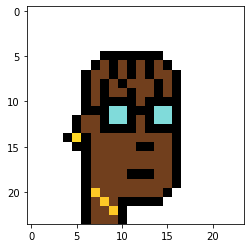

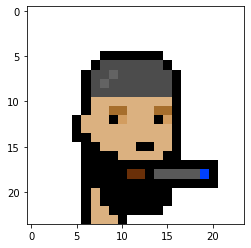

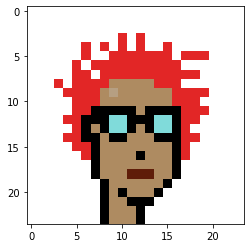

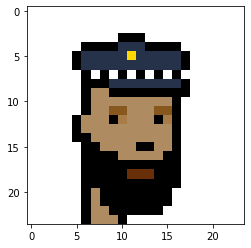

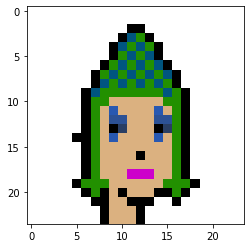

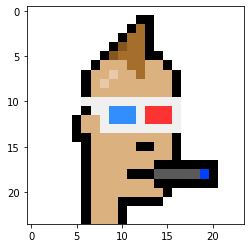

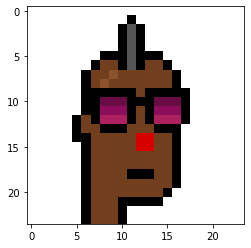

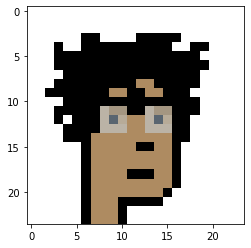

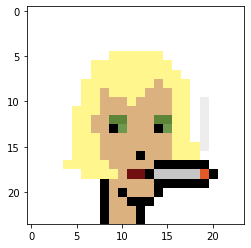

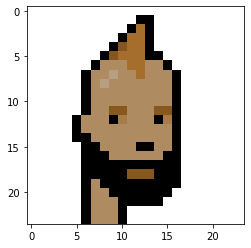

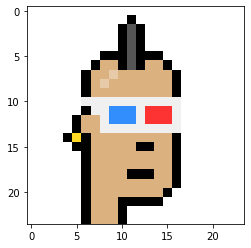

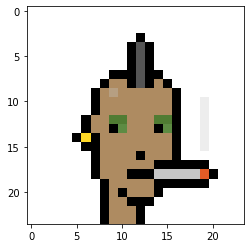

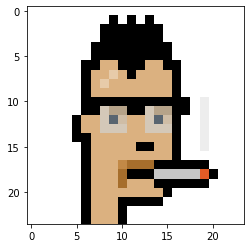

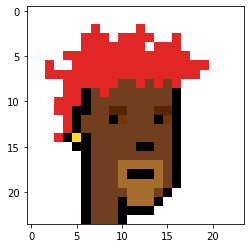

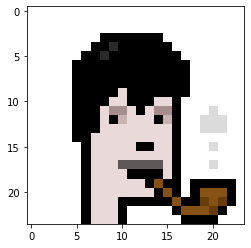

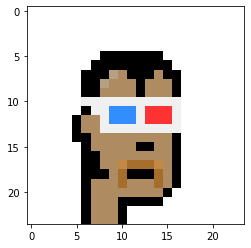

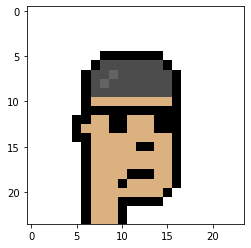

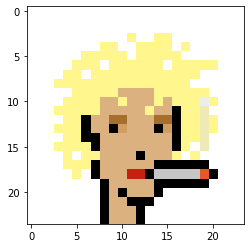

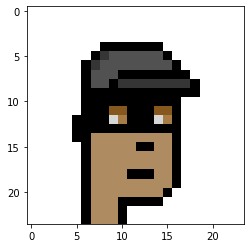

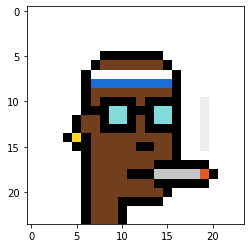

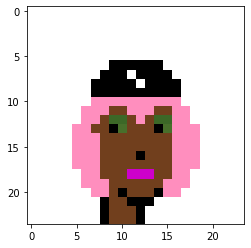

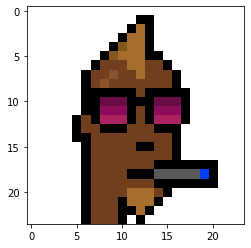

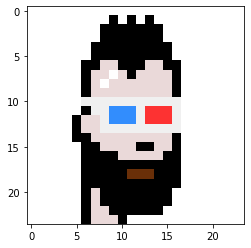

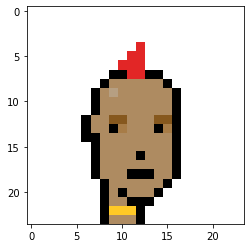

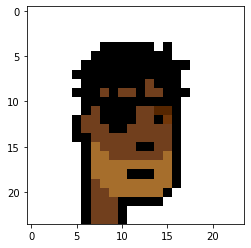

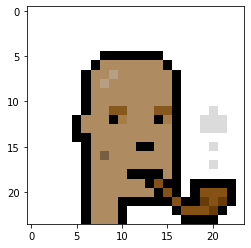

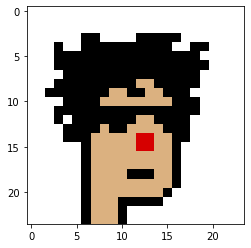

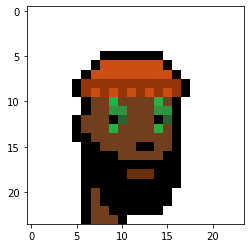

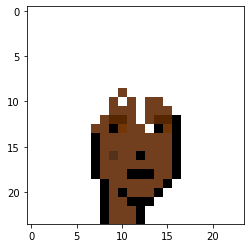

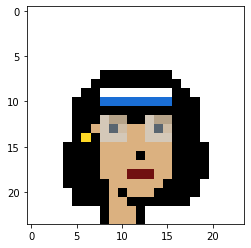

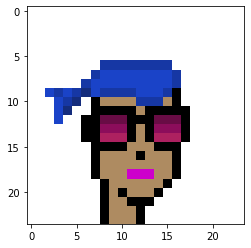

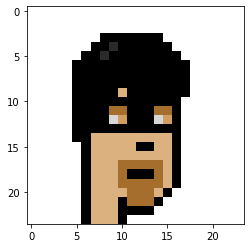

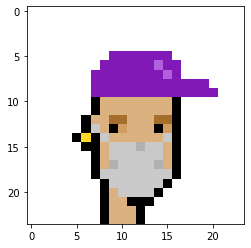

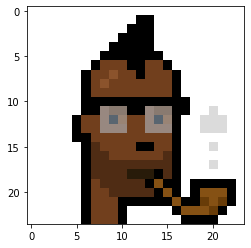

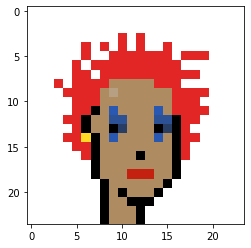

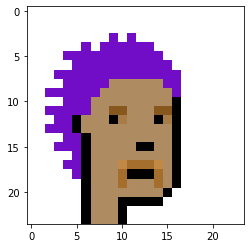

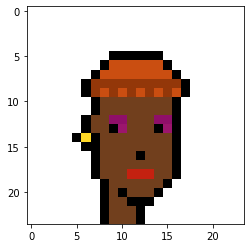

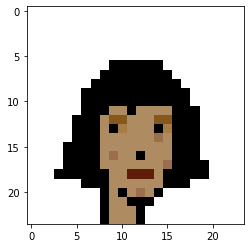

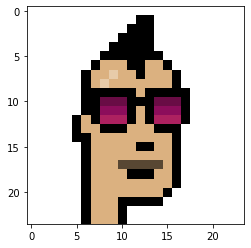

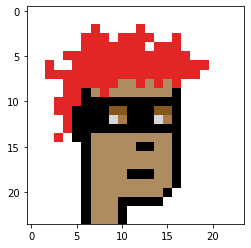

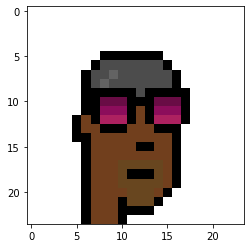

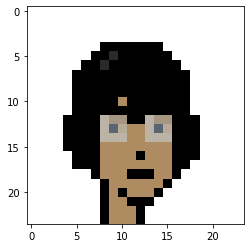

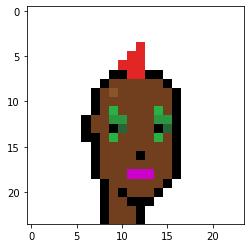

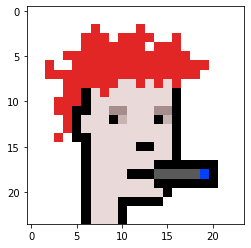

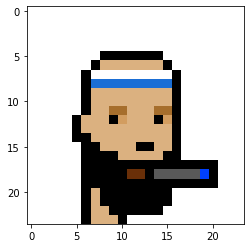

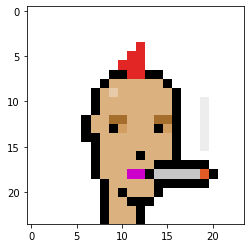

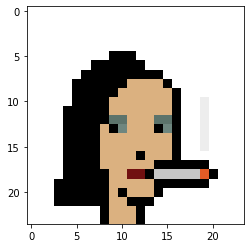

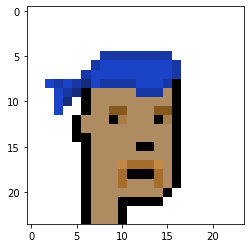

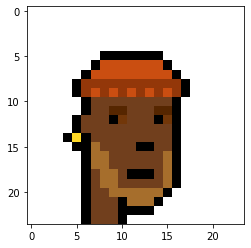

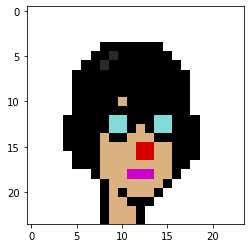

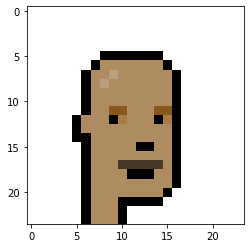

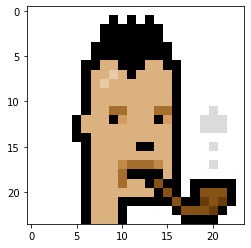

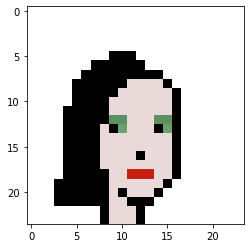

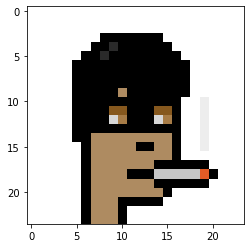

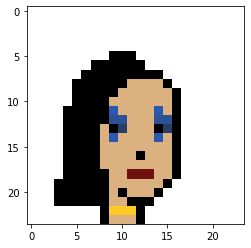

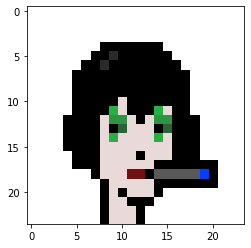

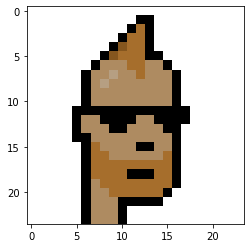

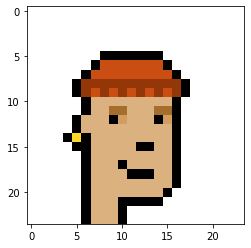

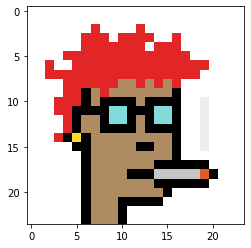

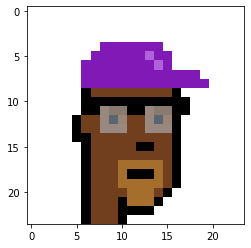

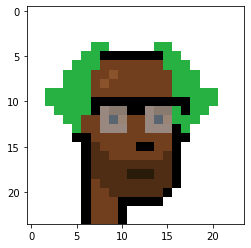

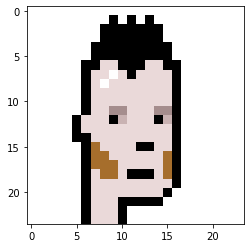

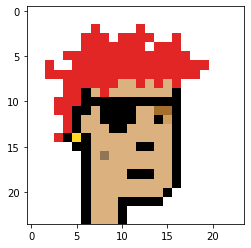

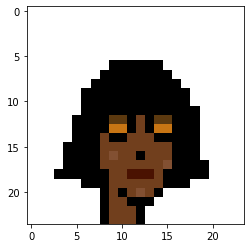

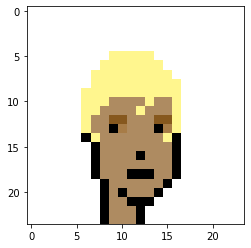

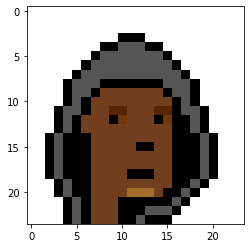

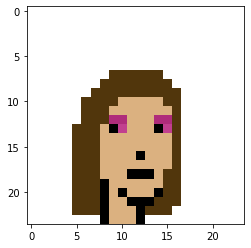

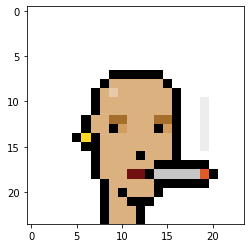

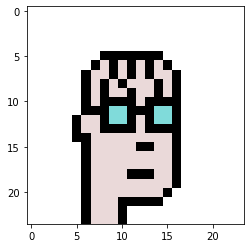

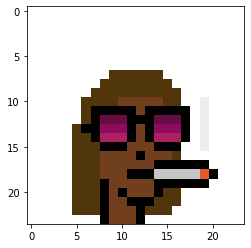

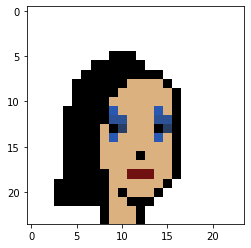

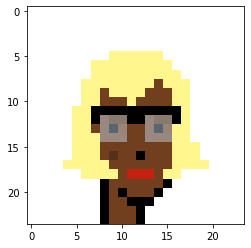

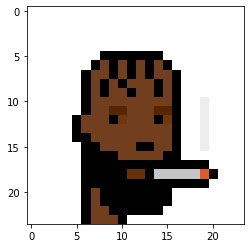

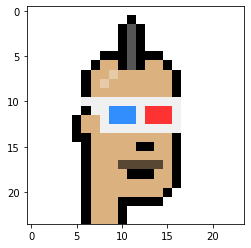

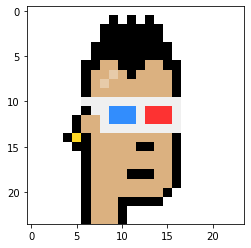

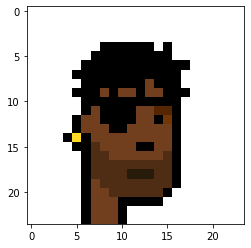

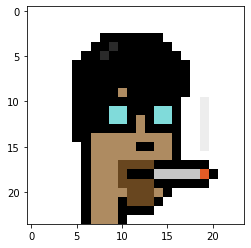

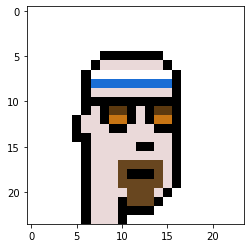

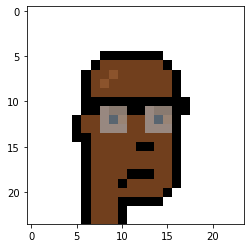

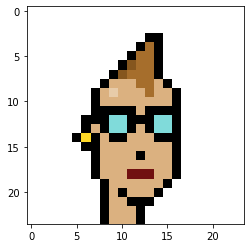

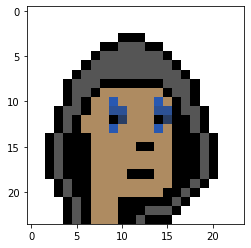

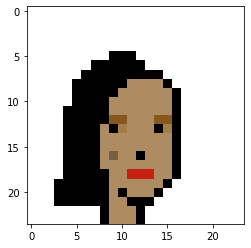

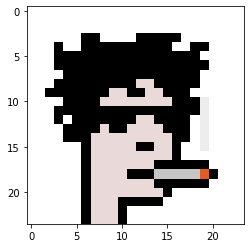

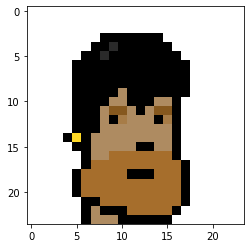

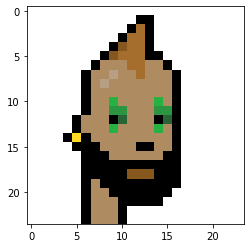

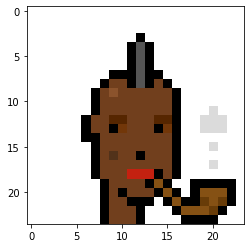

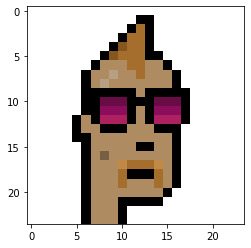

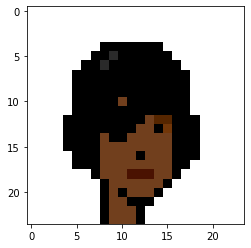

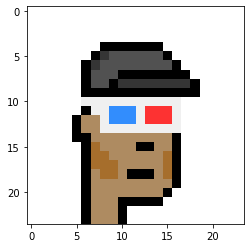

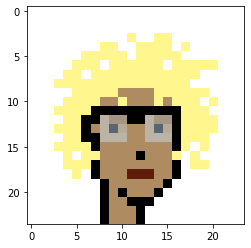

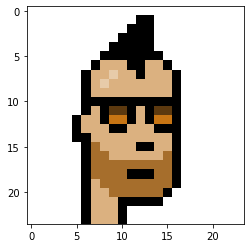

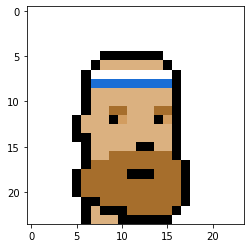

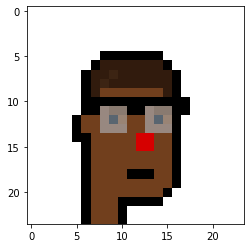

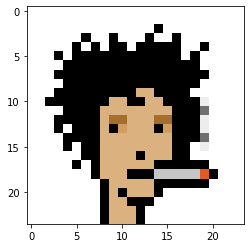

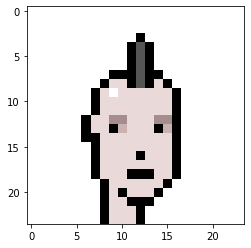

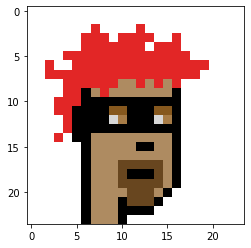

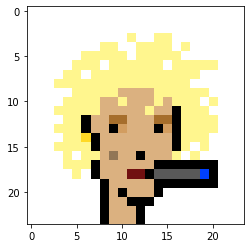

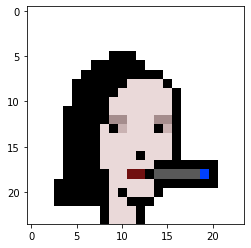

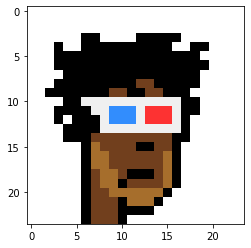

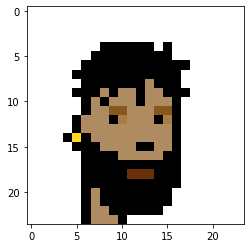

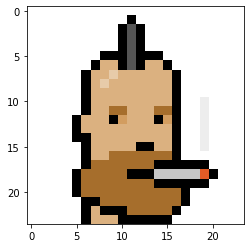

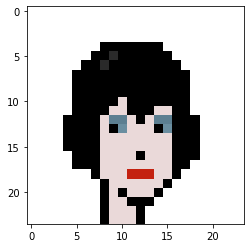

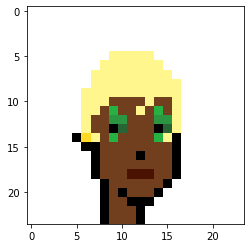

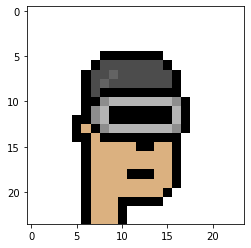

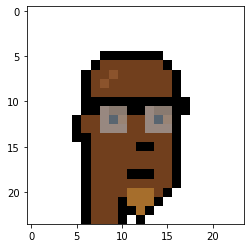

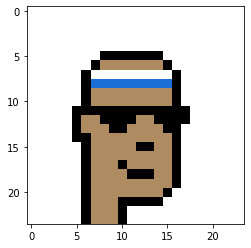

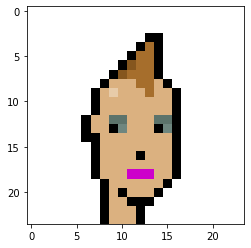

In [15]:
#Shows all the images that are in the table *takes around 5min
import matplotlib.image as mpimg

for index, row in info_table.iterrows():
    image = mpimg.imread(f"data/imgs/{row['punk_id']}.png")
    plt.figure()
    plt.imshow(image)




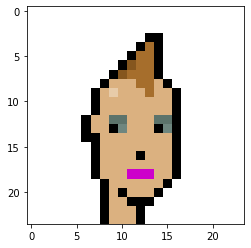

In [16]:
#Nota, imprime el ultimo valor 
plt.imshow(punk_img_rgb_map)